# Business goal

To develop a predictive analytics model that accurately forecasts the cost of medical treatments and procedures. This model aims to enhance financial transparency for patients, optimize pricing strategies for healthcare providers, and contribute to the overall efficiency of the healthcare system by enabling data-driven decision-making. By leveraging historical data and machine learning algorithms, the project seeks to provide reliable price estimates that reflect the complexity and variability of individual patient care, ultimately leading to improved patient satisfaction and trust in healthcare services.

# 0. Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm
from yellowbrick.model_selection import FeatureImportances
import joblib
import shap
import os
%matplotlib inline

# 1. Get the data

## 1.1 Import xlsx file

In [27]:
data = pd.read_excel('dataset/Package Pricing at Mission Hospital - Data Supplement.xlsx', sheet_name='MH-Raw Data')

In [28]:
print(data.columns)

Index(['SL.', 'AGE', 'GENDER', 'MARITAL STATUS', 'KEY COMPLAINTS -CODE',
       'BODY WEIGHT', 'BODY HEIGHT', 'HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR',
       'PAST MEDICAL HISTORY CODE', 'HB', 'UREA', 'CREATININE',
       'MODE OF ARRIVAL', 'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN',
       'TOTAL COST TO HOSPITAL ', 'TOTAL LENGTH OF STAY',
       'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'IMPLANT USED (Y/N)',
       'COST OF IMPLANT'],
      dtype='object')


In [29]:
data.columns = data.columns.str.strip()

In [30]:
data['PAST MEDICAL HISTORY CODE'] = data['PAST MEDICAL HISTORY CODE'].str.capitalize()
data['MODE OF ARRIVAL'] = data['MODE OF ARRIVAL'].str.capitalize()
data['STATE AT THE TIME OF ARRIVAL'] = data['STATE AT THE TIME OF ARRIVAL'].str.capitalize()
data['TYPE OF ADMSN'] = data['TYPE OF ADMSN'].str.capitalize()
data['MARITAL STATUS'] = data['MARITAL STATUS'].str.capitalize()

# 2. Data Preparation

## 2.1 Feature Engineering

In [31]:
#Age Group Bins
data['AGE_GROUP'] = 'Old'

conditions = [
    (data['AGE'] <= 10),
    (data['AGE'] > 10) & (data['AGE'] <= 25),
    (data['AGE'] > 25) & (data['AGE'] <= 50)
]

age_groups = ['Child', 'Youngadult', 'Adult']

data['AGE_GROUP'] = np.select(conditions, age_groups, default='Old')

#Haemoglobin Bins
data['HB_LEVEL'] = 'Normal'

condition = data['HB'] < 11

data.loc[condition, 'HB_LEVEL'] = 'Low'


# Urea Bins
data['UREA_LEVEL'] = np.where(data['UREA'] < 20, 'Normal', 'Abnormal')

# BMI Calculation and Bins
# Calculate BMI
data['BMI_VALUE'] = data['BODY WEIGHT'] / (data['BODY HEIGHT']/100) ** 2

# Create BMI Categories
conditions = [
    (data['BMI_VALUE'] <= 18.5),
    (data['BMI_VALUE'] > 18.5) & (data['BMI_VALUE'] < 25),
    (data['BMI_VALUE'] >= 25) & (data['BMI_VALUE'] < 30),
    (data['BMI_VALUE'] >= 30)
]
categories = ['Underweight', 'Normal', 'Overweight', 'Obese']
data['BMI'] = np.select(conditions, categories, default='Obese')

# Blood Pressure Categories
conditions = [
    (data['BP -HIGH'] < 120) & (data['BP-LOW'] < 80),
    (data['BP -HIGH'] > 119) & (data['BP -HIGH'] < 130) & (data['BP-LOW'] < 80),
    ((data['BP -HIGH'] > 129) & (data['BP -HIGH'] < 140)) | ((data['BP-LOW'] > 79) & (data['BP-LOW'] < 90)),
    (data['BP -HIGH'] >= 140) | (data['BP-LOW'] >= 90),
    (data['BP -HIGH'] > 180) | (data['BP-LOW'] > 120)
]
categories = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
data['BP_Cat'] = np.select(conditions, categories, default='Hypertensive Crisis')

# Creatinine Level Bins
conditions = [
    (data['AGE'] <= 3) & (data['CREATININE'] >= 0.3) & (data['CREATININE'] <= 0.7),
    (data['AGE'] > 3) & (data['AGE'] <= 18) & (data['CREATININE'] >= 0.5) & (data['CREATININE'] <= 1.0),
    (data['AGE'] > 18) & (data['GENDER'] == 'F') & (data['CREATININE'] >= 0.6) & (data['CREATININE'] <= 1.1),
    (data['AGE'] > 18) & (data['GENDER'] == 'M') & (data['CREATININE'] >= 0.9) & (data['CREATININE'] <= 1.3)
]
data['CREATININE_LEVEL'] = np.select(conditions, ['Normal'] * 4, default='Abnormal')

In [32]:
data.to_csv('dataset/data_eda.csv',index=False)

## 2.2 Split the data into training and test sets

In [33]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [34]:
train_original, test_original = data_split(data, 0.2)

In [95]:
train_original.shape

(198, 31)

In [36]:
test_original.shape

(50, 31)

In [37]:
train_original.to_csv('dataset/train.csv',index=False)

In [38]:
test_original.to_csv('dataset/test.csv',index=False)

In [39]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# 3. Explore the data

## 3.1 Quick glance at the data

In [15]:
data.head()

SL.   AGE GENDER MARITAL STATUS KEY COMPLAINTS -CODE  BODY WEIGHT  \
0    1  58.0      M        Married         other- heart         49.2   
1    2  59.0      M        Married              CAD-DVD         41.0   
2    3  82.0      M        Married              CAD-TVD         46.6   
3    4  46.0      M        Married              CAD-DVD         80.0   
4    5  60.0      M        Married              CAD-DVD         58.0   

   BODY HEIGHT  HR PULSE  BP -HIGH  BP-LOW  ...  LENGTH OF STAY- WARD  \
0          160       118     100.0    80.0  ...                    13   
1          155        78      70.0    50.0  ...                    21   
2          164       100     110.0    80.0  ...                     9   
3          173       122     110.0    80.0  ...                     1   
4          175        72     180.0   100.0  ...                    12   

  IMPLANT USED (Y/N)  COST OF IMPLANT  AGE_GROUP  HB_LEVEL UREA_LEVEL  \
0                  Y            38000        Old    Normal   Abnormal   
1                  Y            39690        Old    Normal   Abnormal   
2                  N                0        Old    Normal     Normal   
3                  Y            89450      Adult    Normal   Abnormal   
4                  N                0        Old       Low   Abnormal   

   BMI_VALUE          BMI                BP_Cat  CREATININE_LEVEL  
0  19.218750       Normal  Hypertension Stage 1          Abnormal  
1  17.065557  Underweight                Normal          Abnormal  
2  17.325996  Underweight  Hypertension Stage 1          Abnormal  
3  26.729927   Overweight  Hypertension Stage 1          Abnormal  
4  18.938776       Normal  Hypertension Stage 2          Abnormal  

[5 rows x 31 columns]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL.                           248 non-null    int64  
 1   AGE                           248 non-null    float64
 2   GENDER                        248 non-null    object 
 3   MARITAL STATUS                248 non-null    object 
 4   KEY COMPLAINTS -CODE          212 non-null    object 
 5   BODY WEIGHT                   248 non-null    float64
 6   BODY HEIGHT                   248 non-null    int64  
 7   HR PULSE                      248 non-null    int64  
 8   BP -HIGH                      225 non-null    float64
 9   BP-LOW                        225 non-null    float64
 10  RR                            248 non-null    int64  
 11  PAST MEDICAL HISTORY CODE     75 non-null     object 
 12  HB                            246 non-null    float64
 13  UREA 

In [18]:
data.describe(include='all').T

count unique            top freq           mean  \
SL.                           248.0    NaN            NaN  NaN          124.5   
AGE                           248.0    NaN            NaN  NaN      28.879837   
GENDER                          248      2              M  166            NaN   
MARITAL STATUS                  248      2      UNMARRIED  140            NaN   
KEY COMPLAINTS -CODE            212     13   other- heart   55            NaN   
BODY WEIGHT                   248.0    NaN            NaN  NaN      37.524677   
BODY HEIGHT                   248.0    NaN            NaN  NaN     130.221774   
HR PULSE                      248.0    NaN            NaN  NaN      92.229839   
BP -HIGH                      225.0    NaN            NaN  NaN     115.022222   
BP-LOW                        225.0    NaN            NaN  NaN      71.875556   
RR                            248.0    NaN            NaN  NaN      23.540323   
PAST MEDICAL HISTORY CODE        75      6  Hypertension1   23            NaN   
HB                            246.0    NaN            NaN  NaN      12.894553   
UREA                          235.0    NaN            NaN  NaN      26.581702   
CREATININE                    215.0    NaN            NaN  NaN       0.746977   
MODE OF ARRIVAL                 248      3      Walked in  214            NaN   
STATE AT THE TIME OF ARRIVAL    248      2          Alert  247            NaN   
TYPE OF ADMSN                   248      2       Elective  216            NaN   
TOTAL COST TO HOSPITAL        248.0    NaN            NaN  NaN  198723.330282   
TOTAL LENGTH OF STAY          248.0    NaN            NaN  NaN      11.612903   
LENGTH OF STAY - ICU          248.0    NaN            NaN  NaN       3.475806   
LENGTH OF STAY- WARD          248.0    NaN            NaN  NaN       8.153226   
IMPLANT USED (Y/N)              248      2              N  199            NaN   
COST OF IMPLANT               248.0    NaN            NaN  NaN    8544.201613   
AGE_GROUP                       248      4          Child   96            NaN   
HB_LEVEL                        248      2         Normal  199            NaN   
UREA_LEVEL                      248      2       Abnormal  158            NaN   
BMI_VALUE                     248.0    NaN            NaN  NaN      23.321399   
BMI                             248      4    Underweight  132            NaN   
BP_Cat                          248      5         Normal  111            NaN   
CREATININE_LEVEL                248      2       Abnormal  130            NaN   

                                        std       min        25%        50%  \
SL.                               71.735626       1.0      62.75      124.5   
AGE                               25.899359  0.032877        6.0       15.5   
GENDER                                  NaN       NaN        NaN        NaN   
MARITAL STATUS                          NaN       NaN        NaN        NaN   
KEY COMPLAINTS -CODE                    NaN       NaN        NaN        NaN   
BODY WEIGHT                       23.118822      2.02       15.0       40.9   
BODY HEIGHT                       39.170901      19.0      105.0      147.5   
HR PULSE                           20.30874      41.0       78.0       90.0   
BP -HIGH                          22.536368      70.0      100.0      110.0   
BP-LOW                            15.313176      39.0       60.0       70.0   
RR                                 3.840756      12.0       22.0       24.0   
PAST MEDICAL HISTORY CODE               NaN       NaN        NaN        NaN   
HB                                 3.083237       5.0       11.3      12.35   
UREA                              15.998367       2.0       18.0       22.0   
CREATININE                         0.548641       0.1        0.3        0.7   
MODE OF ARRIVAL                         NaN       NaN        NaN        NaN   
STATE AT THE TIME OF ARRIVAL            NaN       NaN        NaN        NaN   
TYPE OF ADMSN  

## 3.2 Functions used in the EDA of each feature

In [19]:
def explore_features(df):
    # Define the numerical and categorical features
    numerical_features = ['AGE', 'BODY WEIGHT', 'BODY HEIGHT', 'HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR', 'HB', 'UREA', 'CREATININE', 'TOTAL COST TO HOSPITAL', 'TOTAL LENGTH OF STAY', 'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'COST OF IMPLANT', 'BMI_VALUE']
    categorical_features = ['GENDER', 'MARITAL STATUS', 'KEY COMPLAINTS -CODE', 'PAST MEDICAL HISTORY CODE', 'MODE OF ARRIVAL', 'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN', 'IMPLANT USED (Y/N)', 'AGE_GROUP', 'HB_LEVEL', 'UREA_LEVEL', 'BMI', 'BP_Cat', 'CREATININE_LEVEL']

    # Explore numerical features
    print("Numerical Features Statistics:")
    for feature in numerical_features:
        if feature in df.columns:
            print(f"\n{feature} Statistics:")
            print(df[feature].describe())
        else:
            print(f"\n{feature} is not in the dataframe.")

    # Explore categorical features
    print("\nCategorical Features Unique Values:")
    for feature in categorical_features:
        if feature in df.columns:
            print(f"\n{feature} Unique Values Count:")
            print(df[feature].value_counts())
        else:
            print(f"\n{feature} is not in the dataframe.")

In [20]:
def create_charts(df):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Bar Graph for Categorical Features
    categorical_features = ['GENDER', 'MARITAL STATUS', 'KEY COMPLAINTS -CODE', 'MODE OF ARRIVAL', 'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN', 'IMPLANT USED (Y/N)', 'AGE_GROUP', 'HB_LEVEL', 'UREA_LEVEL', 'BMI', 'BP_Cat', 'CREATININE_LEVEL']
    for feature in categorical_features:
        if feature in df.columns:
            plt.figure(figsize=(8, 5))
            sns.countplot(x=feature, data=df)
            plt.title(f'Bar Graph for {feature}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # Box Plot for Numerical Features
    numerical_features = ['AGE', 'BODY WEIGHT', 'BODY HEIGHT', 'HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR', 'HB', 'UREA', 'CREATININE', 'TOTAL COST TO HOSPITAL', 'TOTAL LENGTH OF STAY', 'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'COST OF IMPLANT', 'BMI_VALUE']
    for feature in numerical_features:
        if feature in df.columns:
            plt.figure(figsize=(8, 5))
            sns.boxplot(y=feature, data=df)
            plt.title(f'Box Plot for {feature}')
            plt.tight_layout()
            plt.show()

    # Histogram with Density Plot for Numerical Features
    for feature in numerical_features:
        if feature in df.columns:
            plt.figure(figsize=(8, 5))
            sns.histplot(df[feature], kde=True)
            plt.title(f'Histogram with Density Plot for {feature}')
            plt.tight_layout()
            plt.show()

## 3.3. Univariate analysis

In [21]:
explore_features(data)

Numerical Features Statistics:

AGE Statistics:
count    248.000000
mean      28.879837
std       25.899359
min        0.032877
25%        6.000000
50%       15.500000
75%       55.000000
max       88.000000
Name: AGE, dtype: float64

BODY WEIGHT Statistics:
count    248.000000
mean      37.524677
std       23.118822
min        2.020000
25%       15.000000
50%       40.900000
75%       58.250000
max       85.000000
Name: BODY WEIGHT, dtype: float64

BODY HEIGHT Statistics:
count    248.000000
mean     130.221774
std       39.170901
min       19.000000
25%      105.000000
50%      147.500000
75%      160.000000
max      185.000000
Name: BODY HEIGHT, dtype: float64

HR PULSE Statistics:
count    248.000000
mean      92.229839
std       20.308740
min       41.000000
25%       78.000000
50%       90.000000
75%      104.000000
max      155.000000
Name: HR PULSE, dtype: float64

BP -HIGH Statistics:
count    225.000000
mean     115.022222
std       22.536368
min       70.000000
25%      100.

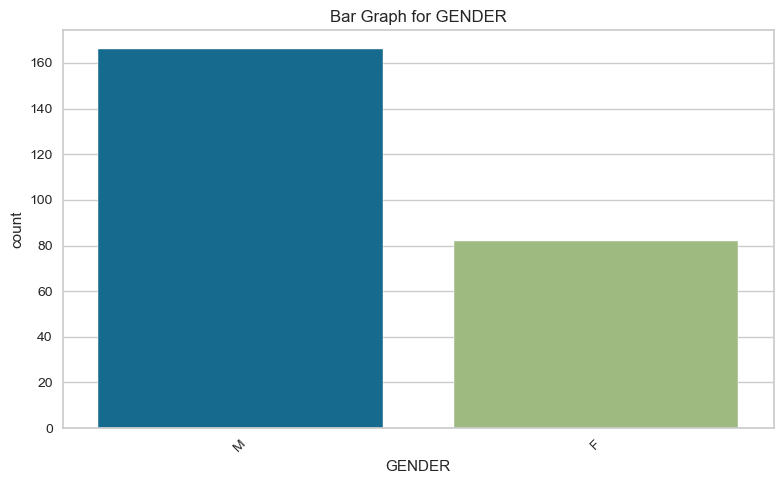

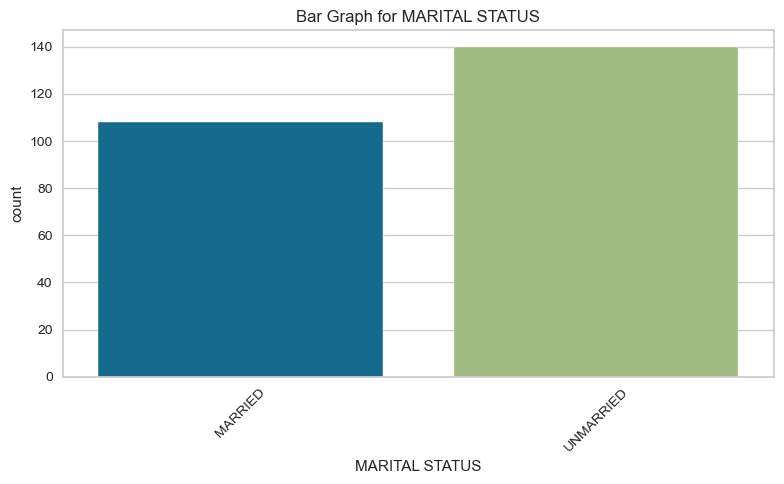

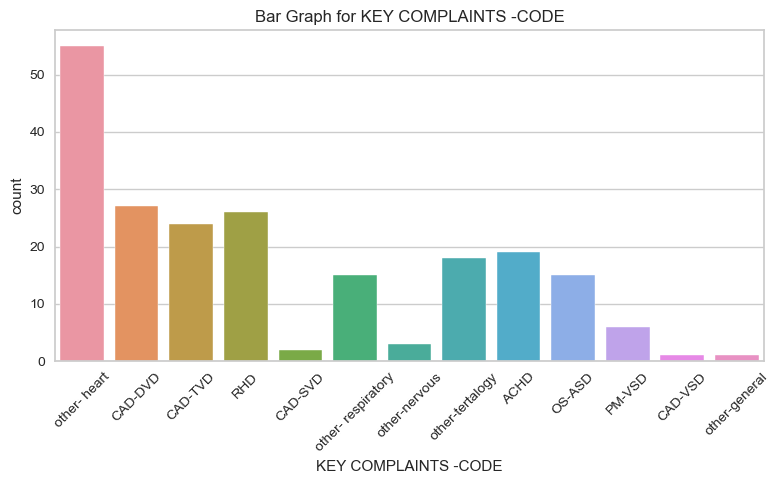

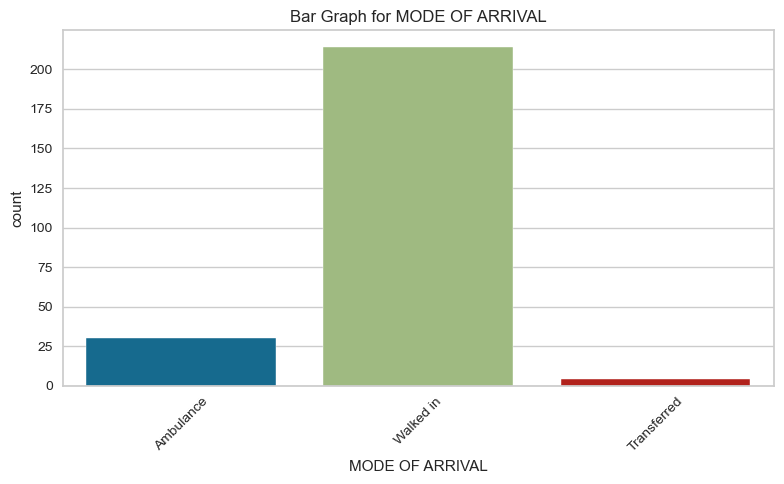

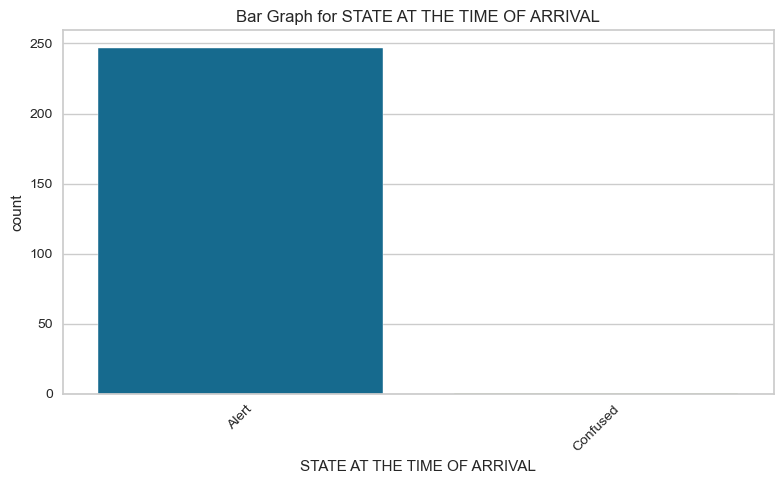

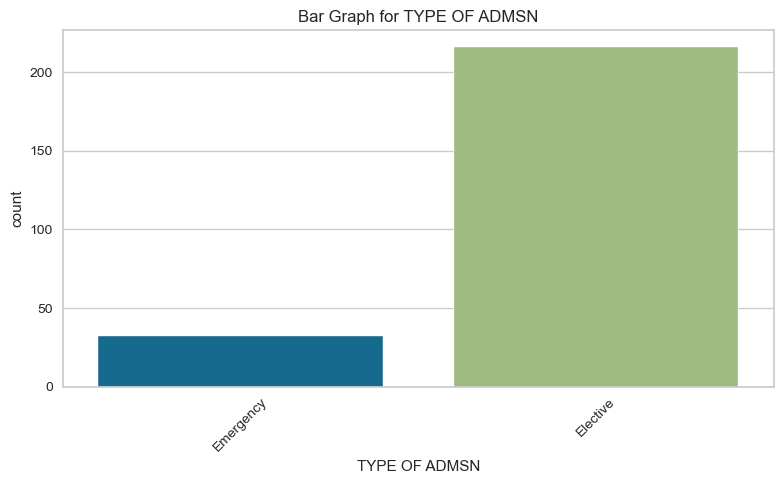

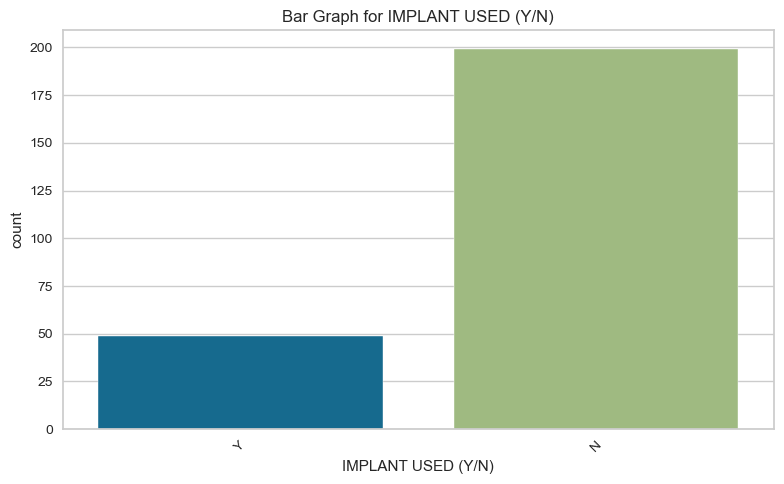

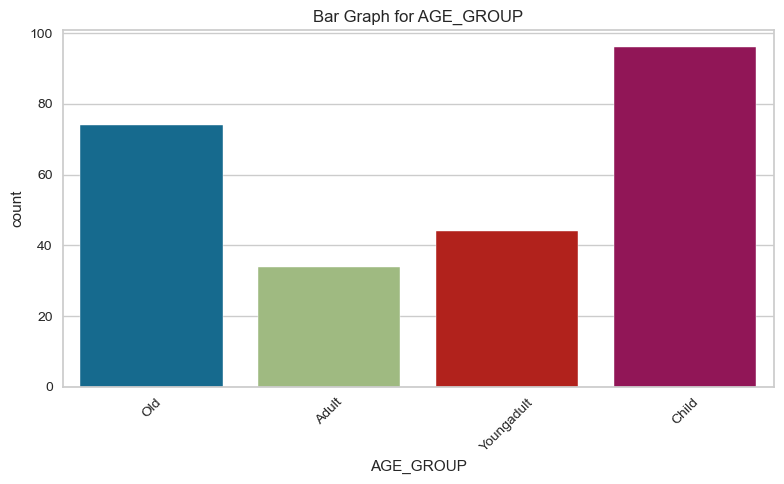

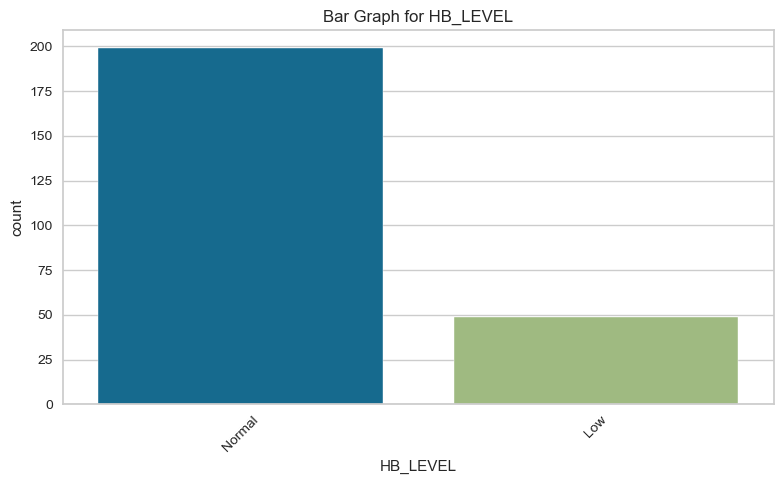

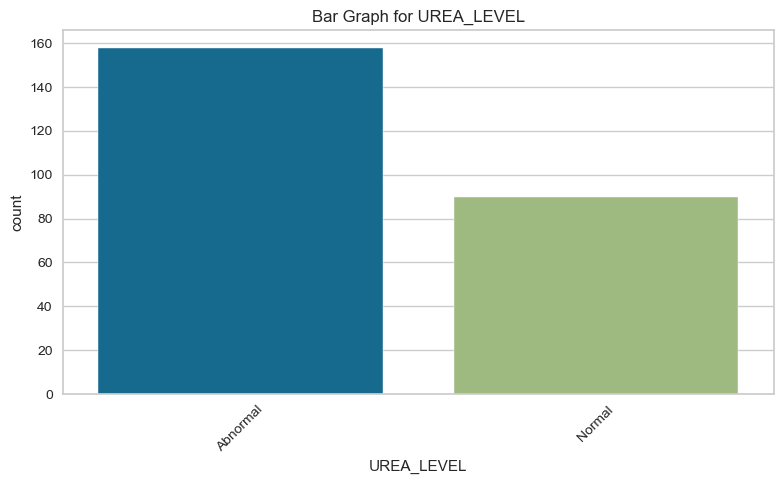

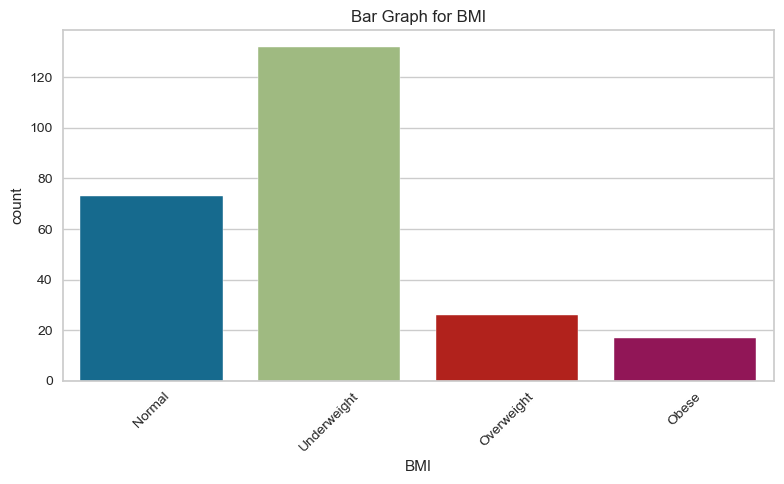

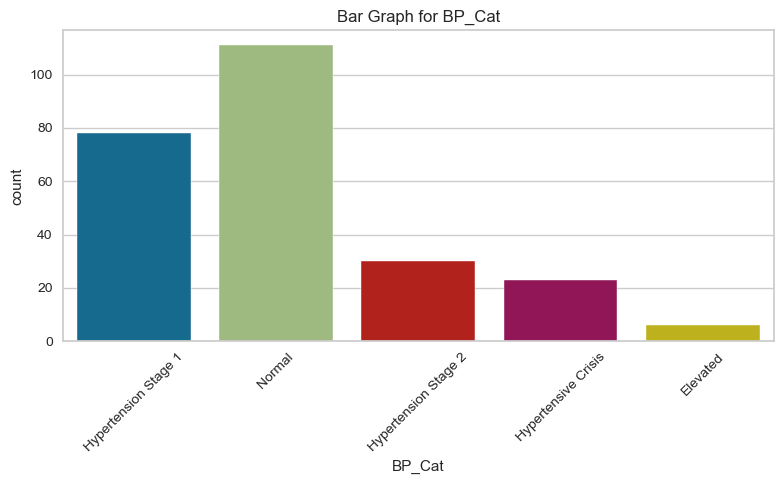

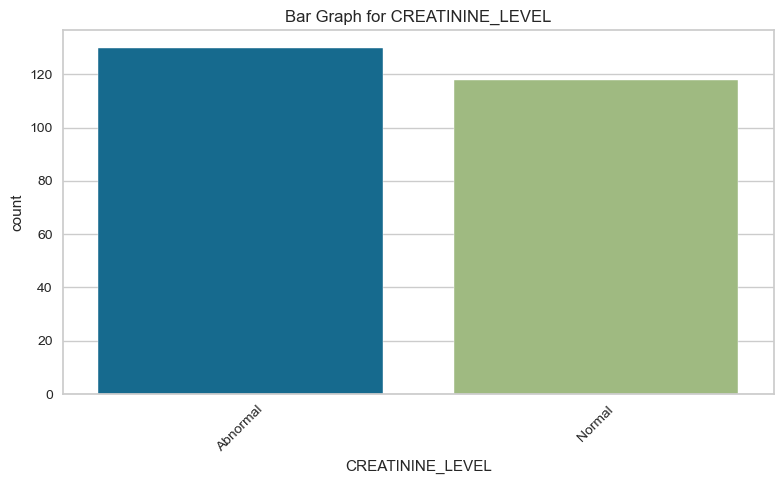

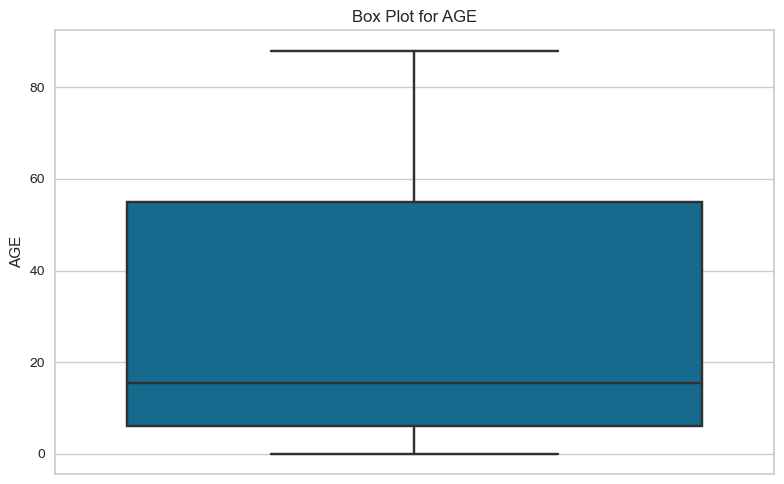

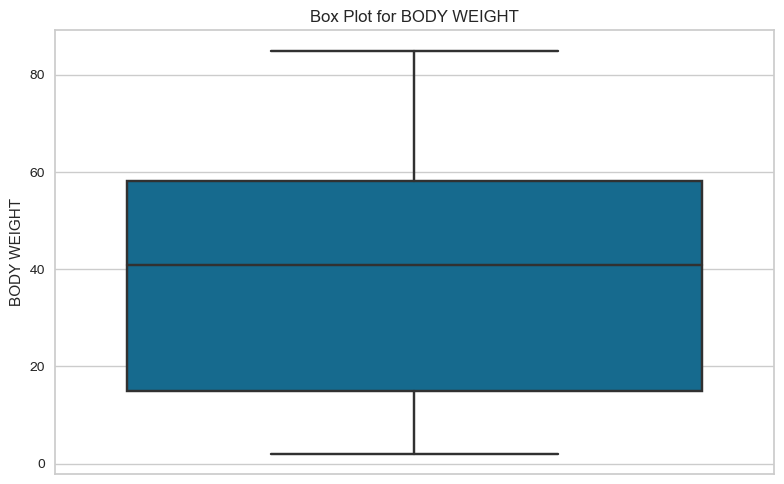

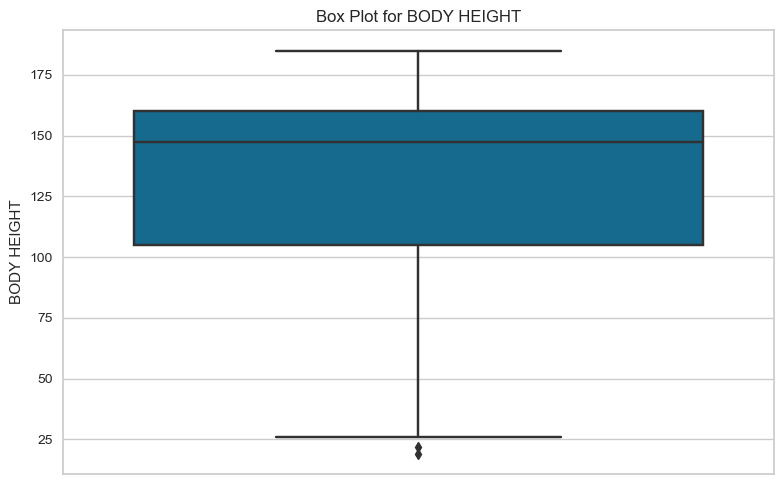

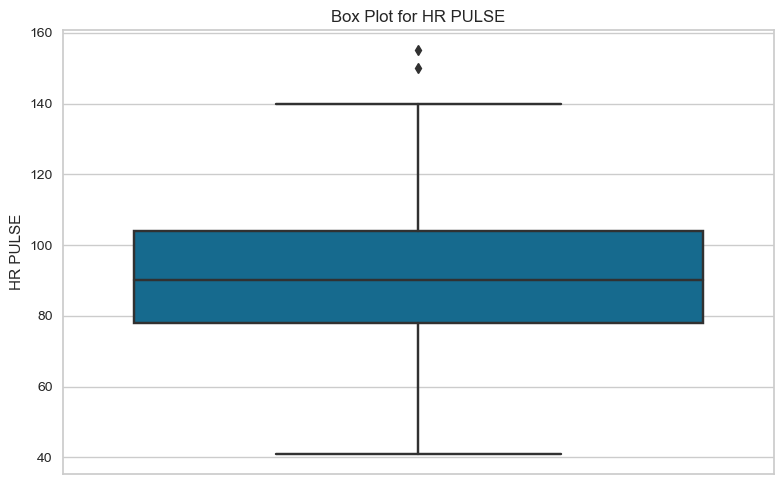

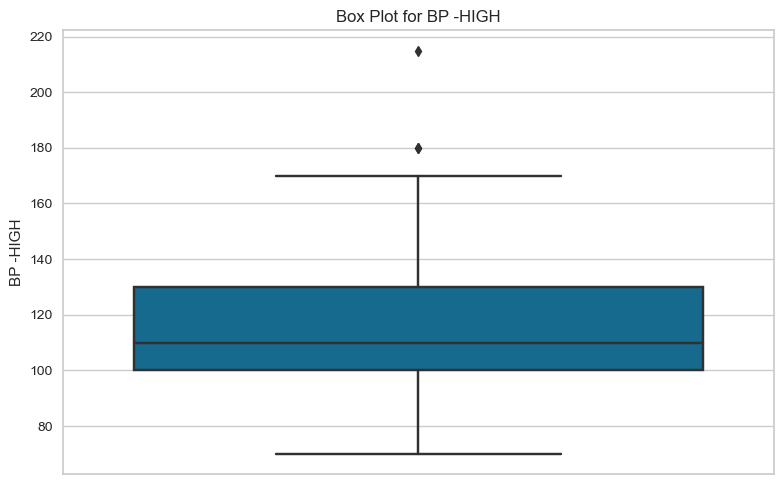

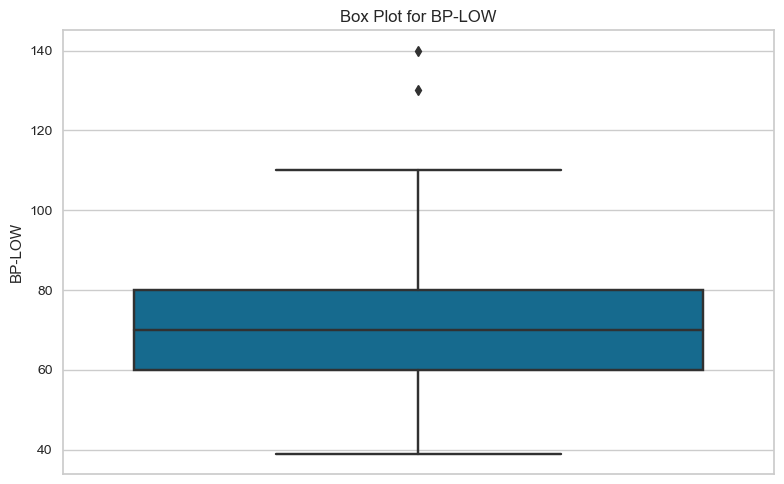

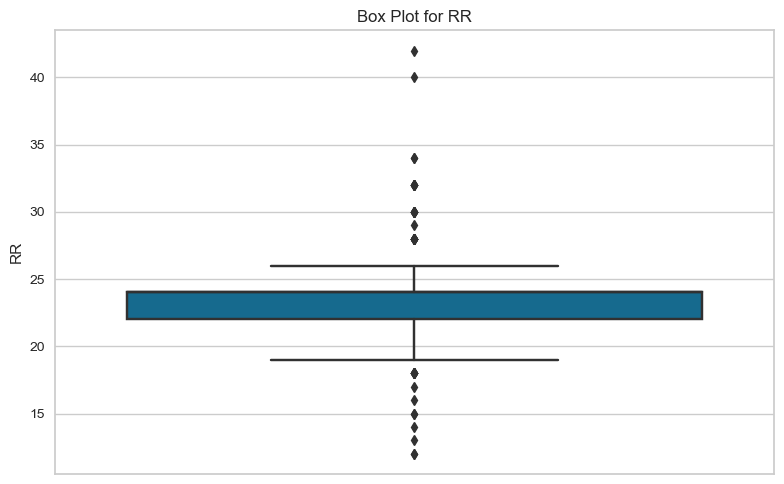

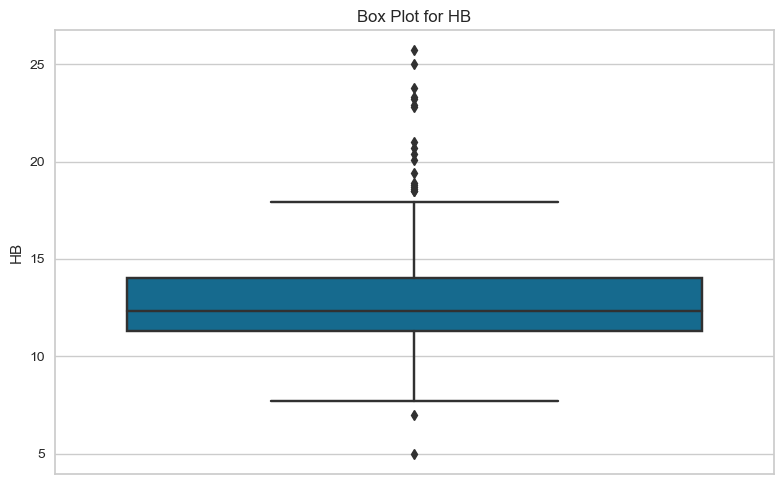

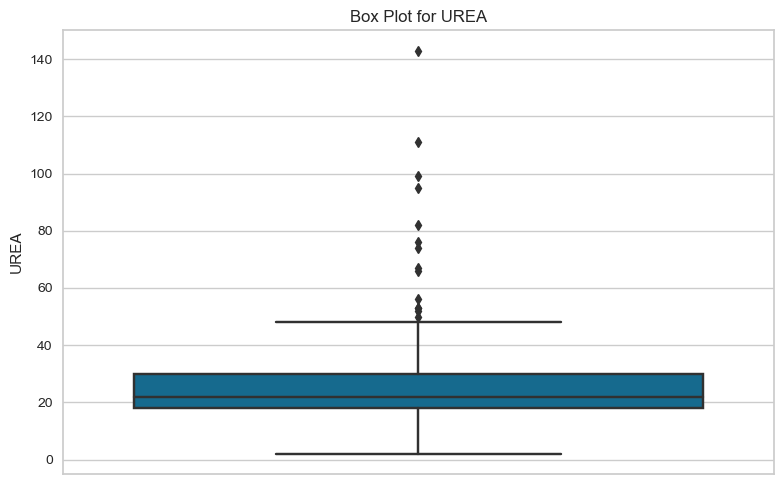

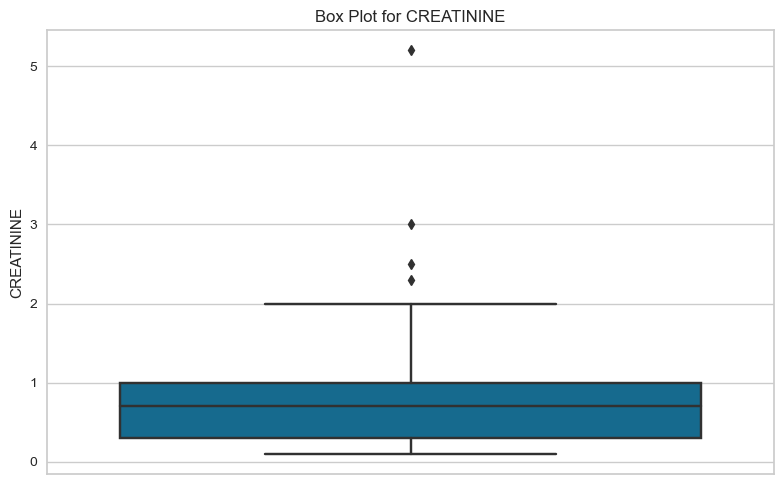

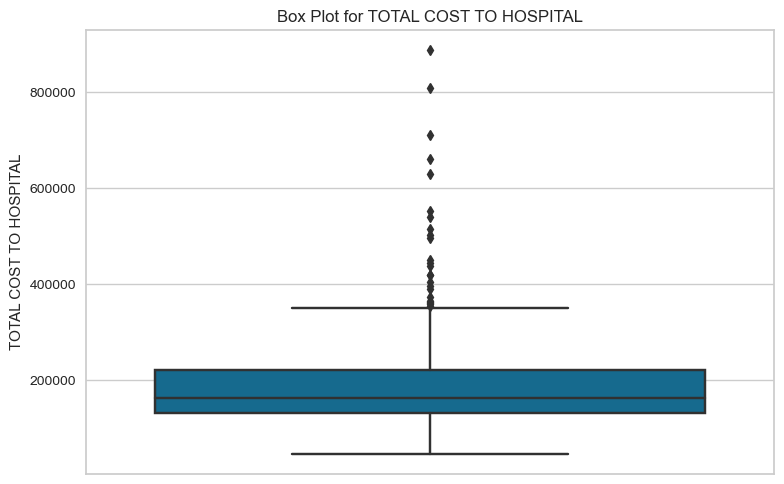

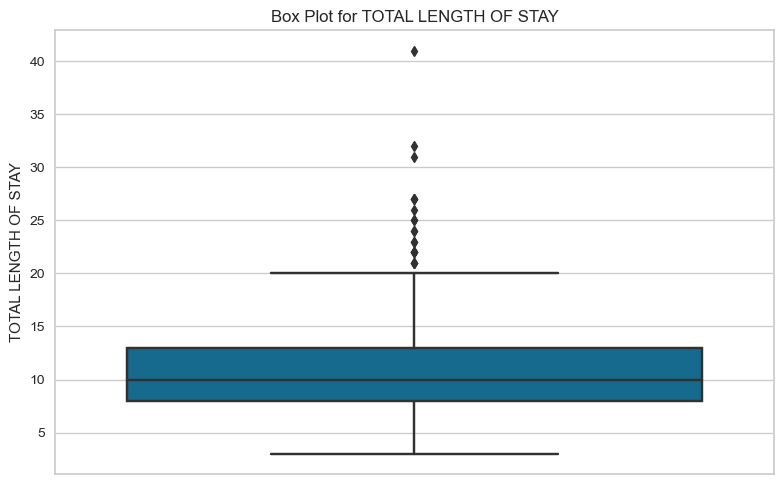

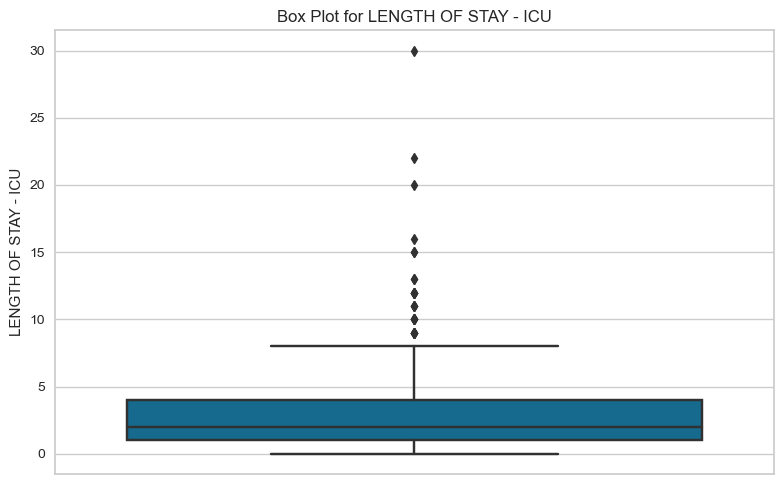

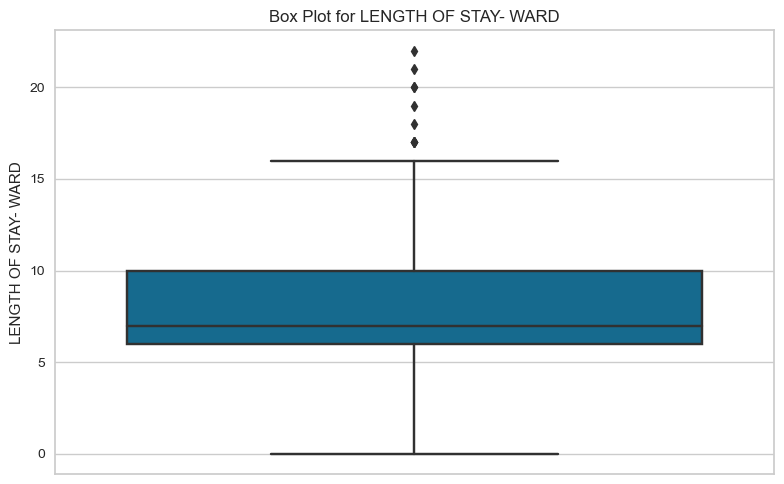

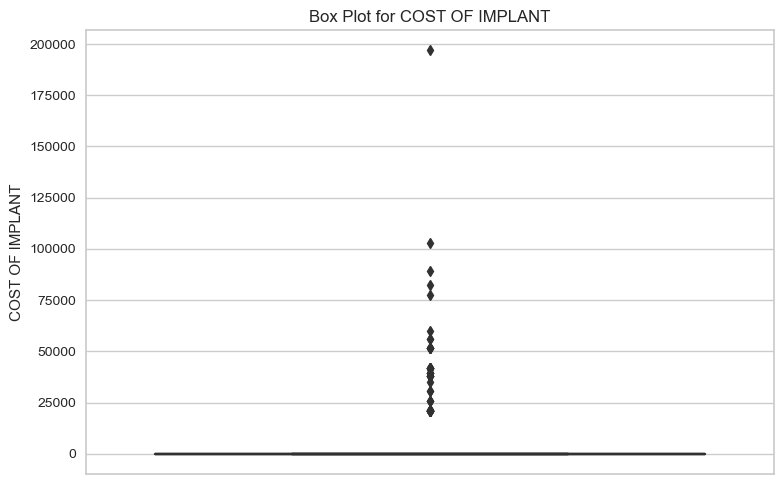

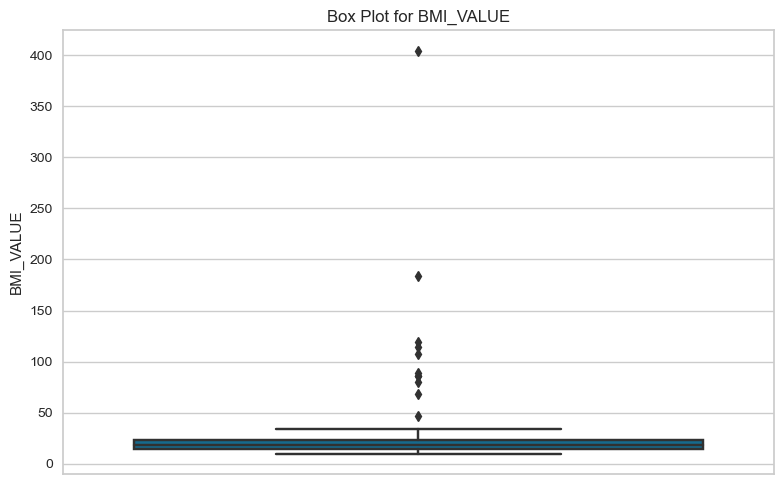

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


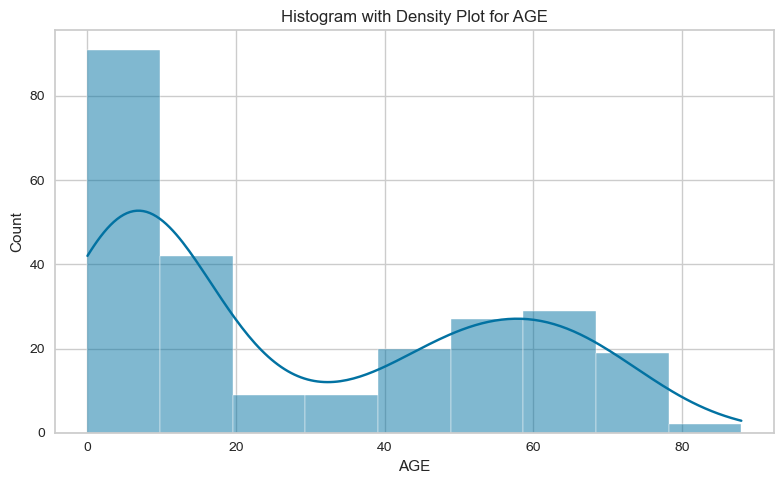

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


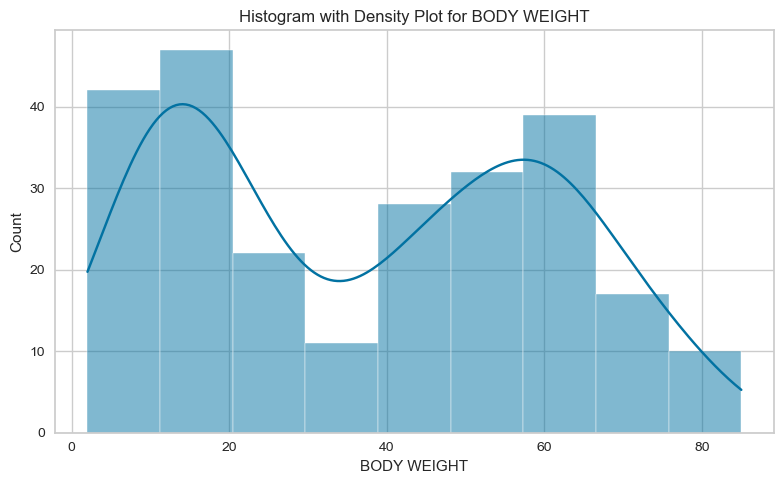

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


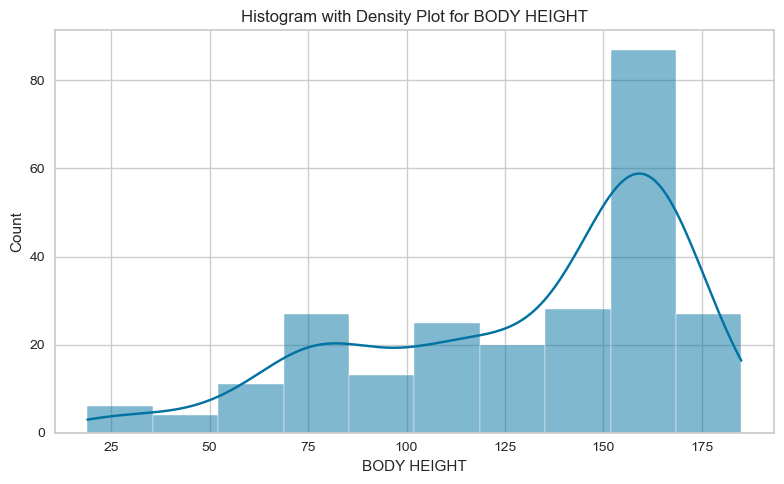

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


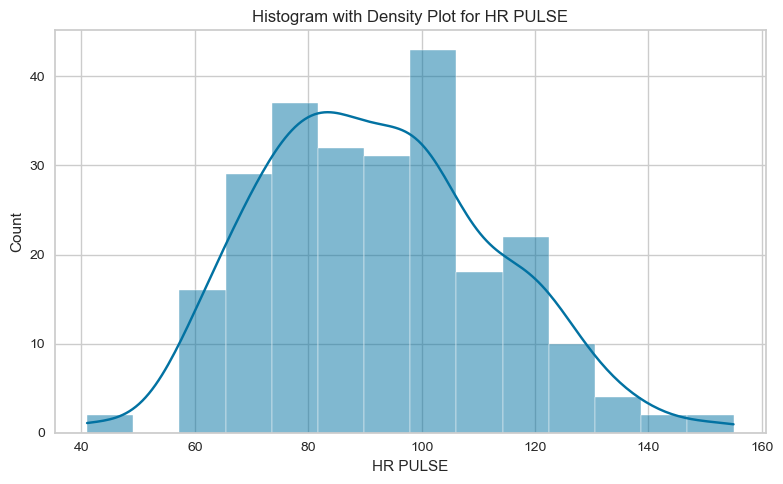

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


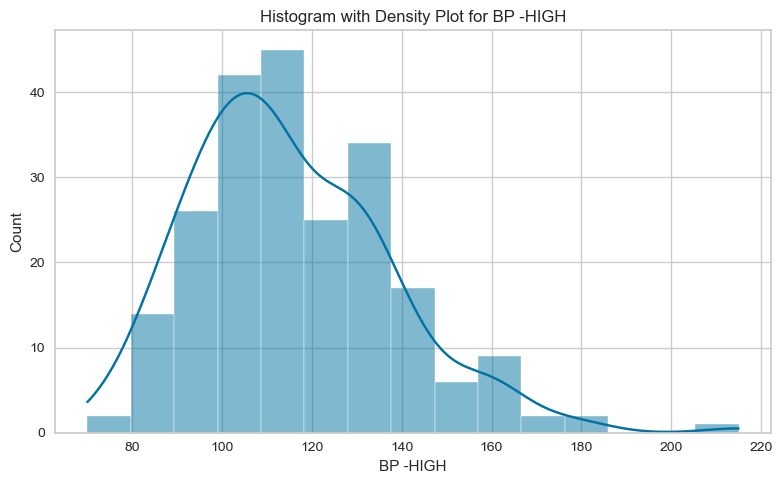

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


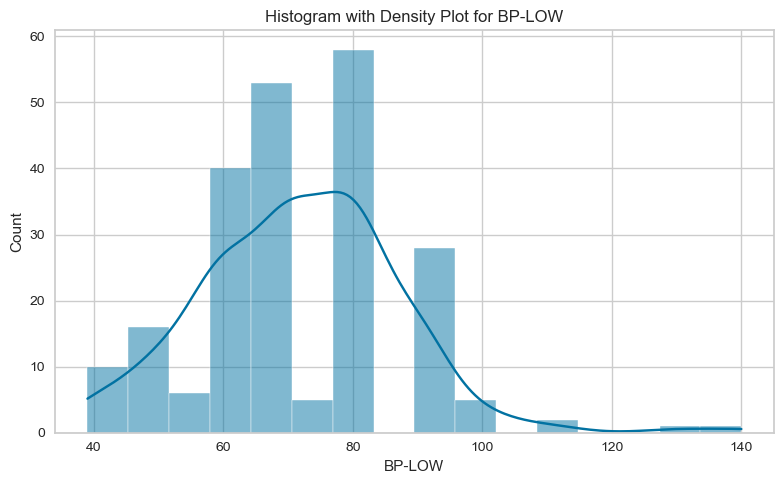

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


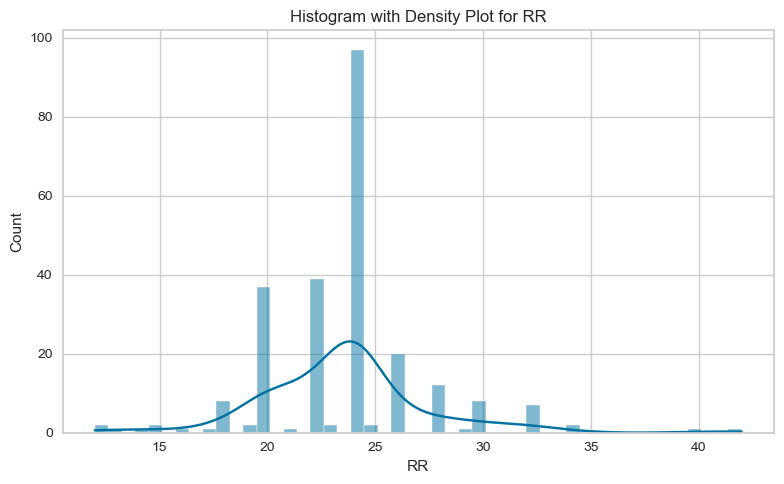

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


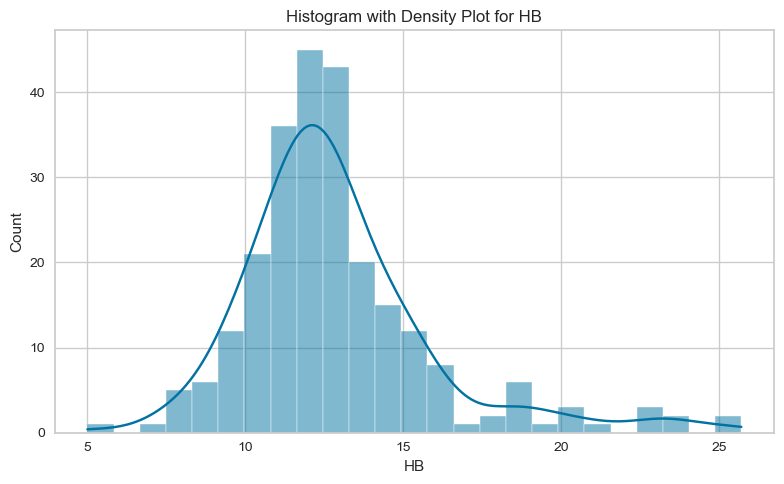

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


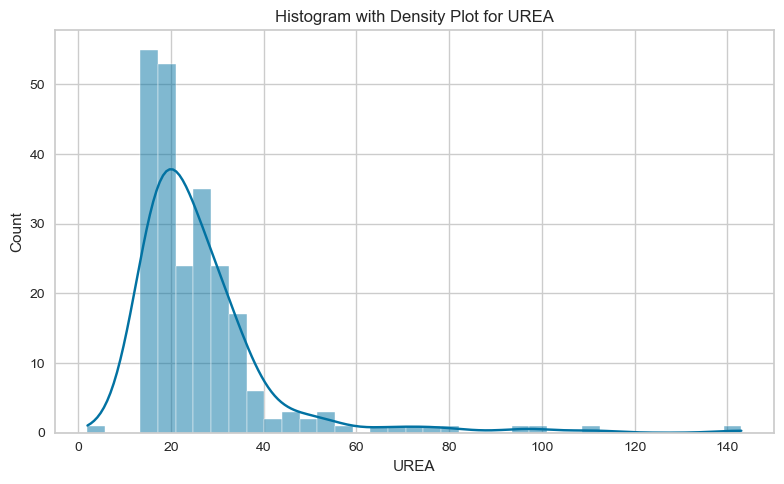

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


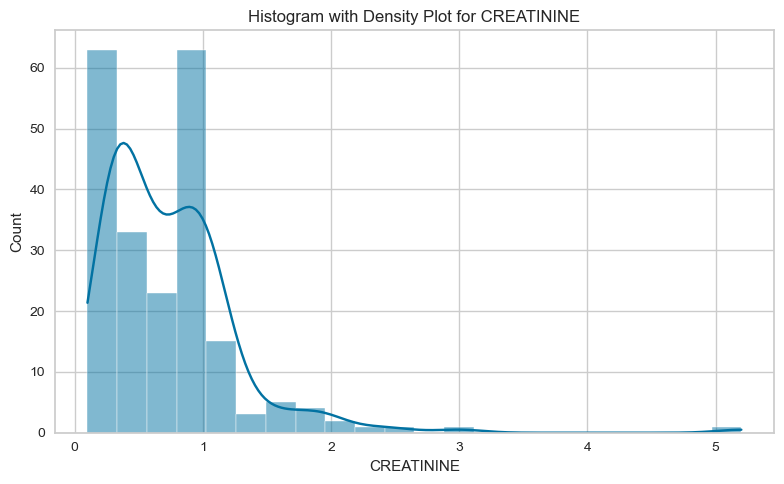

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


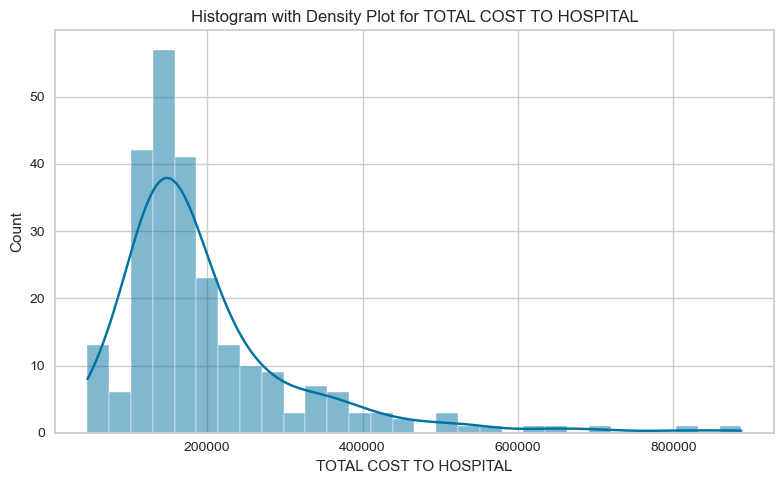

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


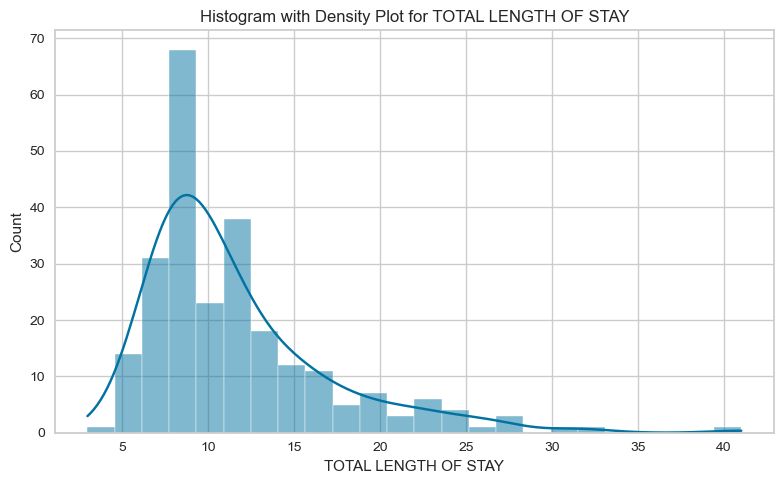

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


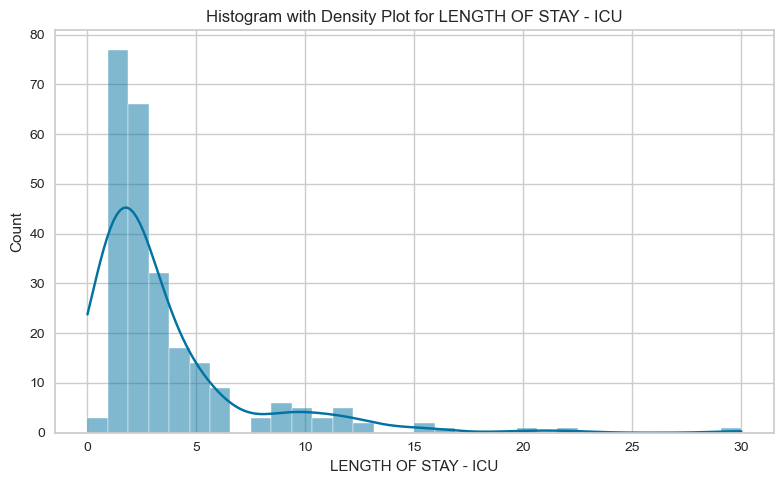

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


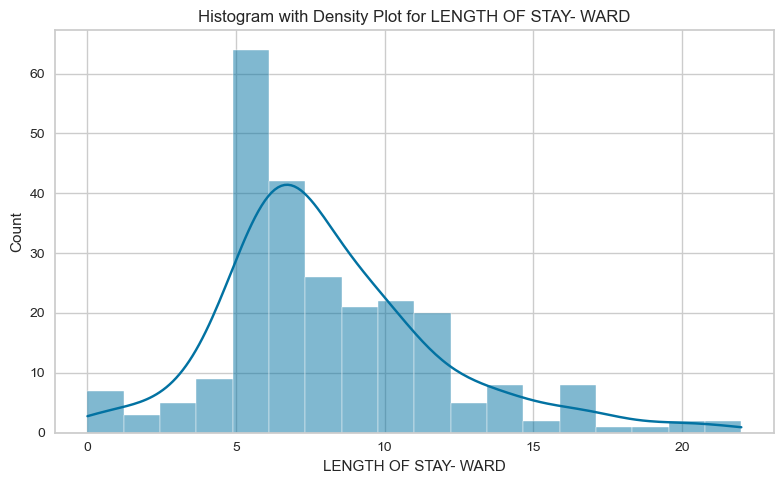

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


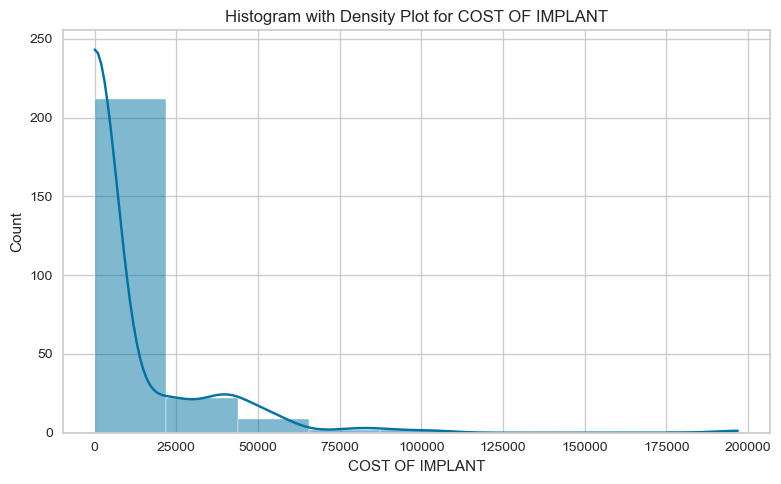

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


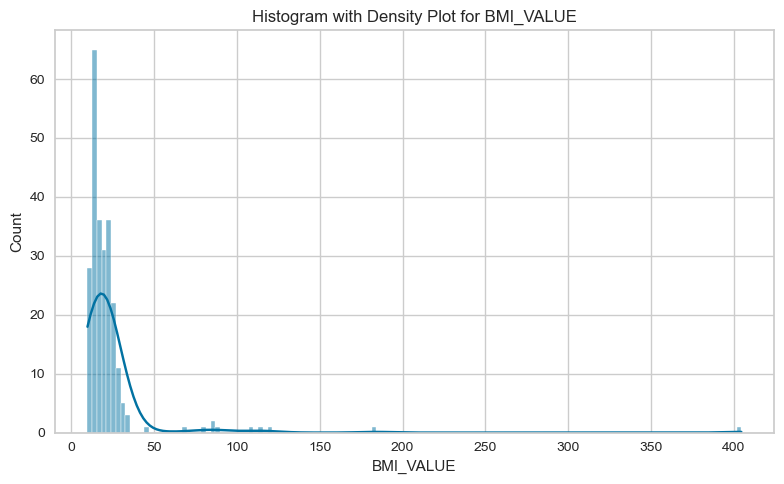

In [22]:
create_charts(data)

## 3.4 Bivariate Analysis

### 3.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 3.4.1.1 Scatter plots

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

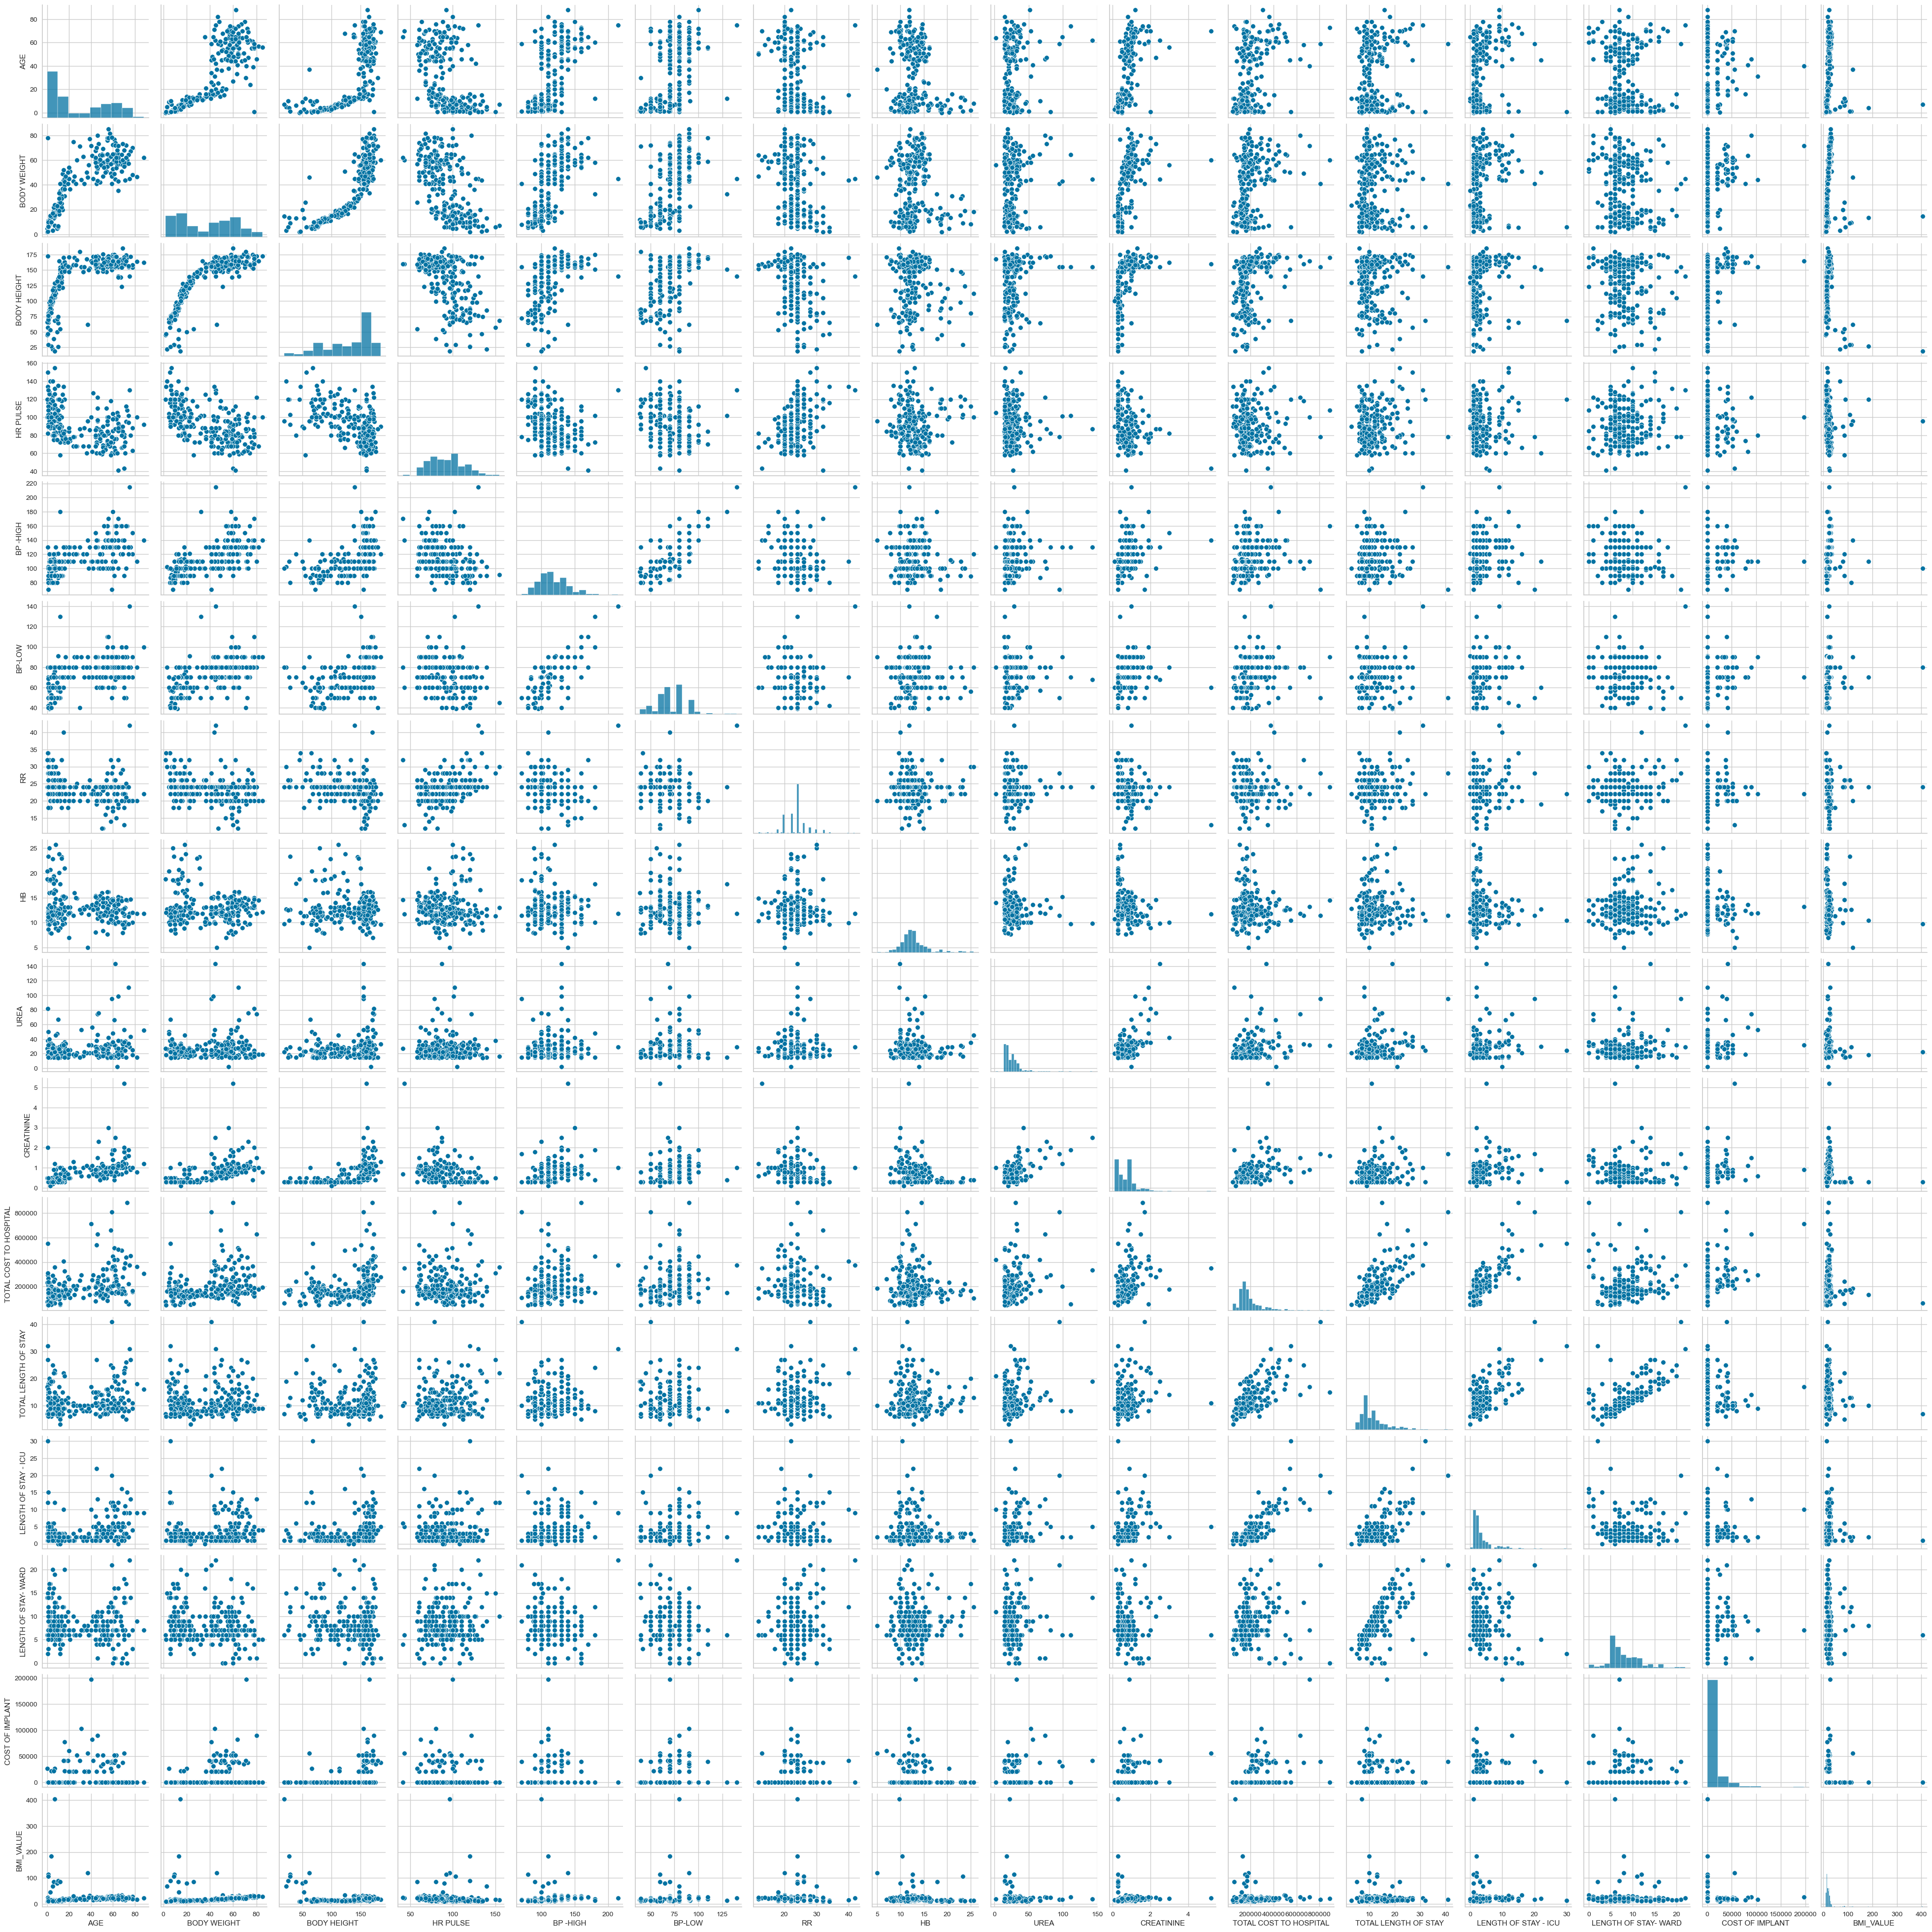

In [104]:
# Select only the numerical columns for the scatter plot matrix
numerical_df = data.select_dtypes(include=['float64', 'int64'])

# Drop the 'SL' column from the DataFrame
numerical_df = numerical_df.drop('SL.', axis=1)

# Create a pairplot to visualize the relationships between numerical variables
sns.pairplot(numerical_df)
plt.show()

##### 3.4.1.1.1 Body Height vs Total Cost To Hospital

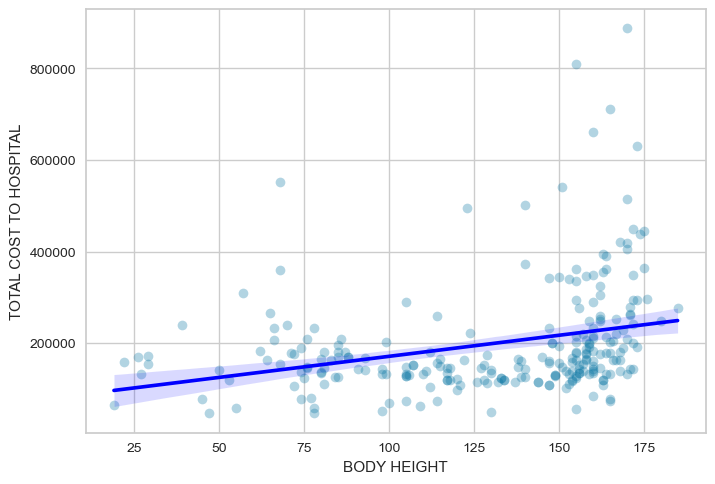

In [101]:
sns.regplot(x='BODY HEIGHT',y='TOTAL COST TO HOSPITAL',data=data,line_kws={'color':'blue'},scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.2 Body Weight vs Total Cost To Hospital

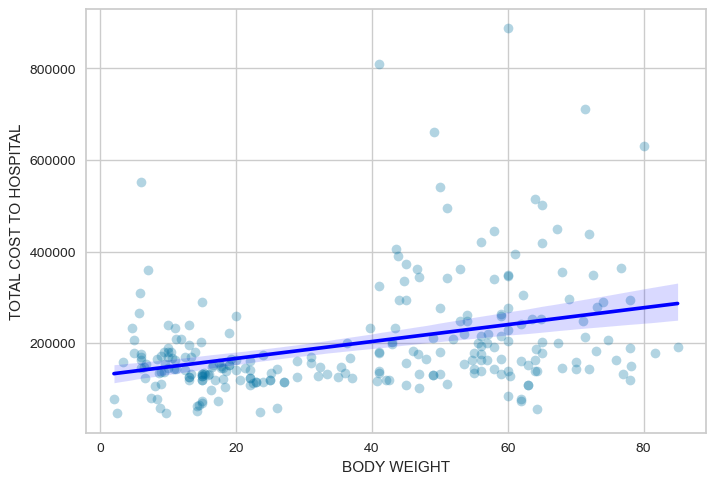

In [100]:
sns.regplot(x='BODY WEIGHT',y='TOTAL COST TO HOSPITAL',data=data,line_kws={'color':'blue'},scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.3 Age vs Total Cost To Hospital

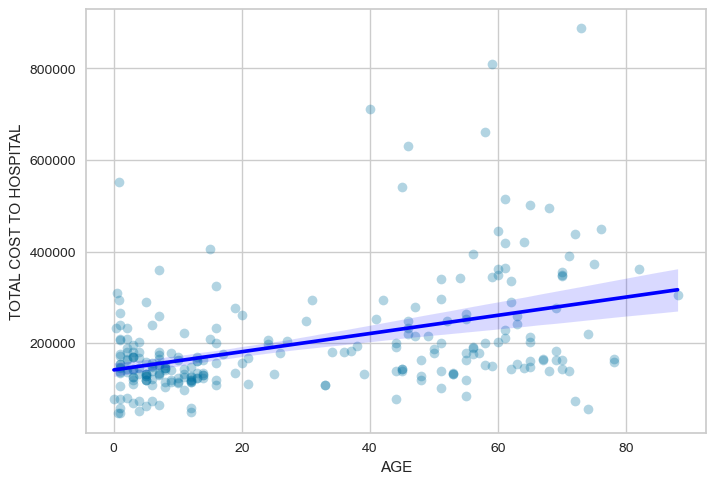

In [89]:
sns.regplot(x='AGE', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.4 Length Of Stay vs Total Cost To Hospital

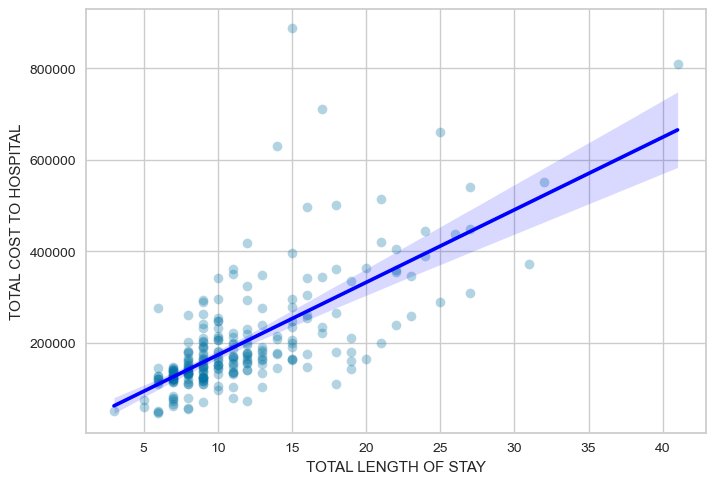

In [94]:
sns.regplot(x='TOTAL LENGTH OF STAY', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.5 HR Pulse vs Total Cost To Hospital

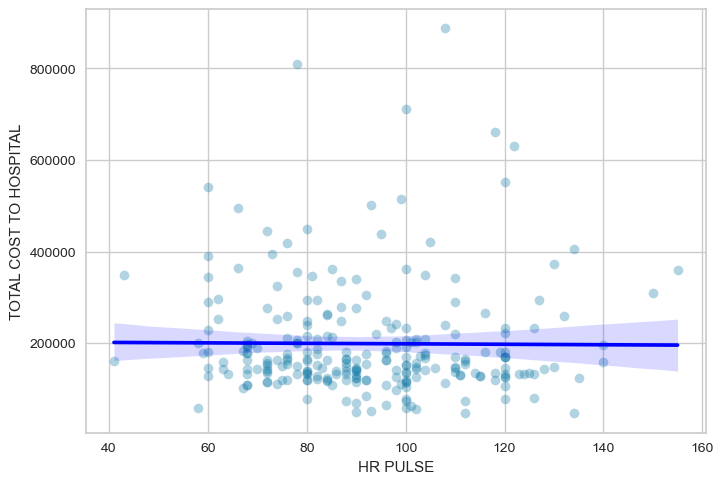

In [95]:
sns.regplot(x='HR PULSE', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.6 BP-High vs Total Cost To Hospital

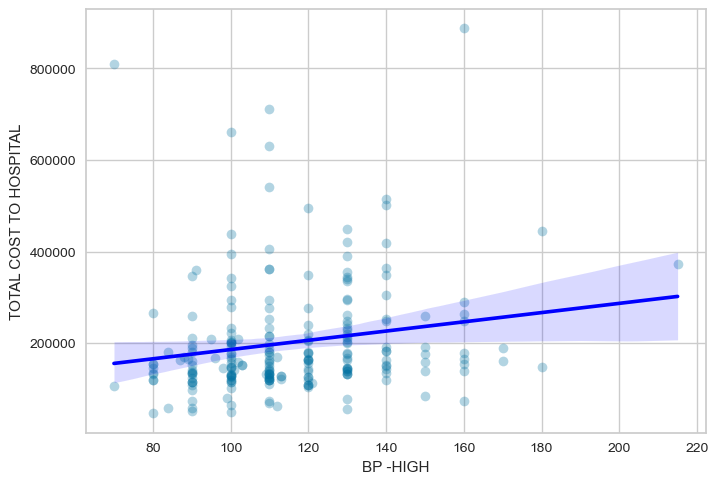

In [96]:
sns.regplot(x='BP -HIGH', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.7 BP-Low vs Total Cost To Hospital

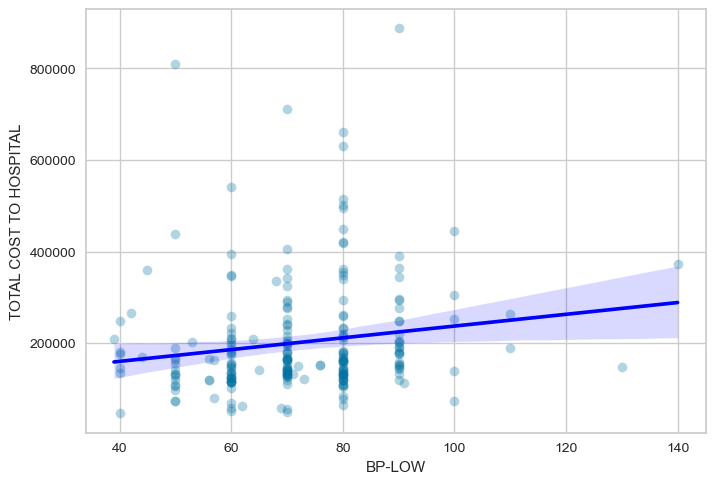

In [97]:
sns.regplot(x='BP-LOW', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.8 HB vs Total Cost To Hospital

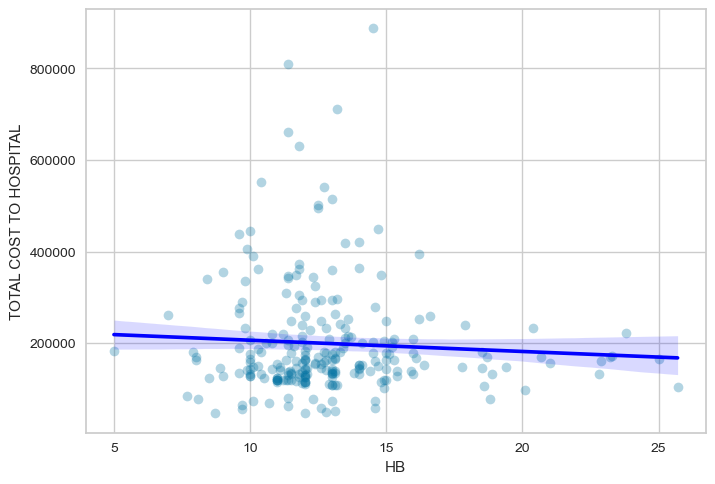

In [98]:
sns.regplot(x='HB', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.9 UREA vs Total Cost To Hospital

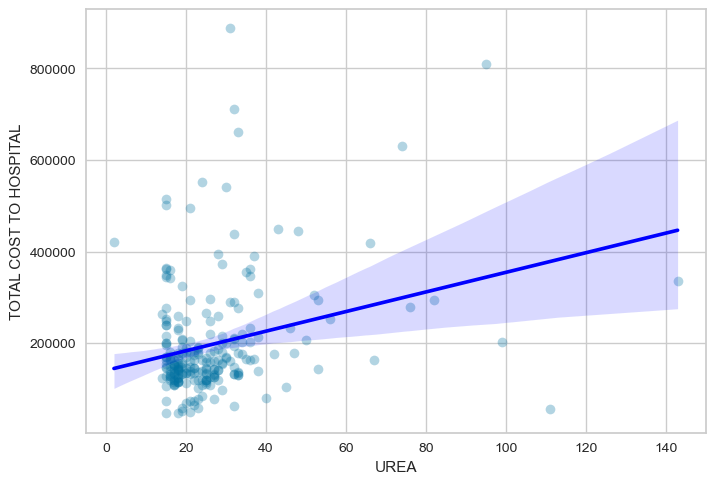

In [99]:
sns.regplot(x='UREA', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

##### 3.4.1.1.10 CREATININE vs Total Cost To Hospital

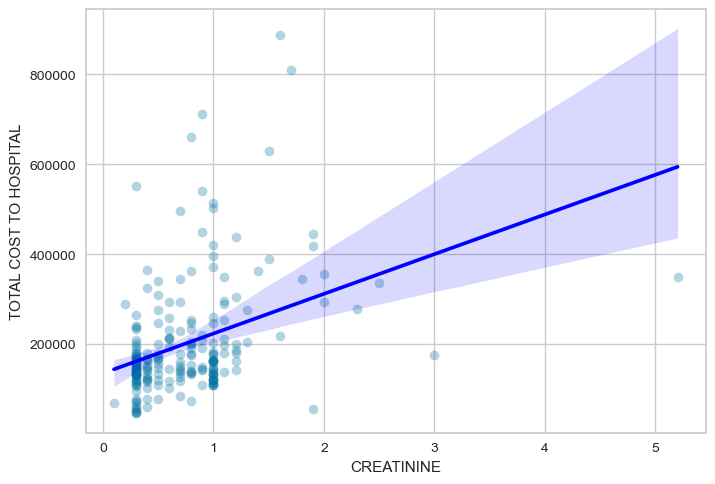

In [92]:
sns.regplot(x='CREATININE', y='TOTAL COST TO HOSPITAL', data=data, line_kws={'color':'blue'}, scatter_kws={'alpha':0.3})
plt.show()

#### 3.4.1.2 Correlation analysis

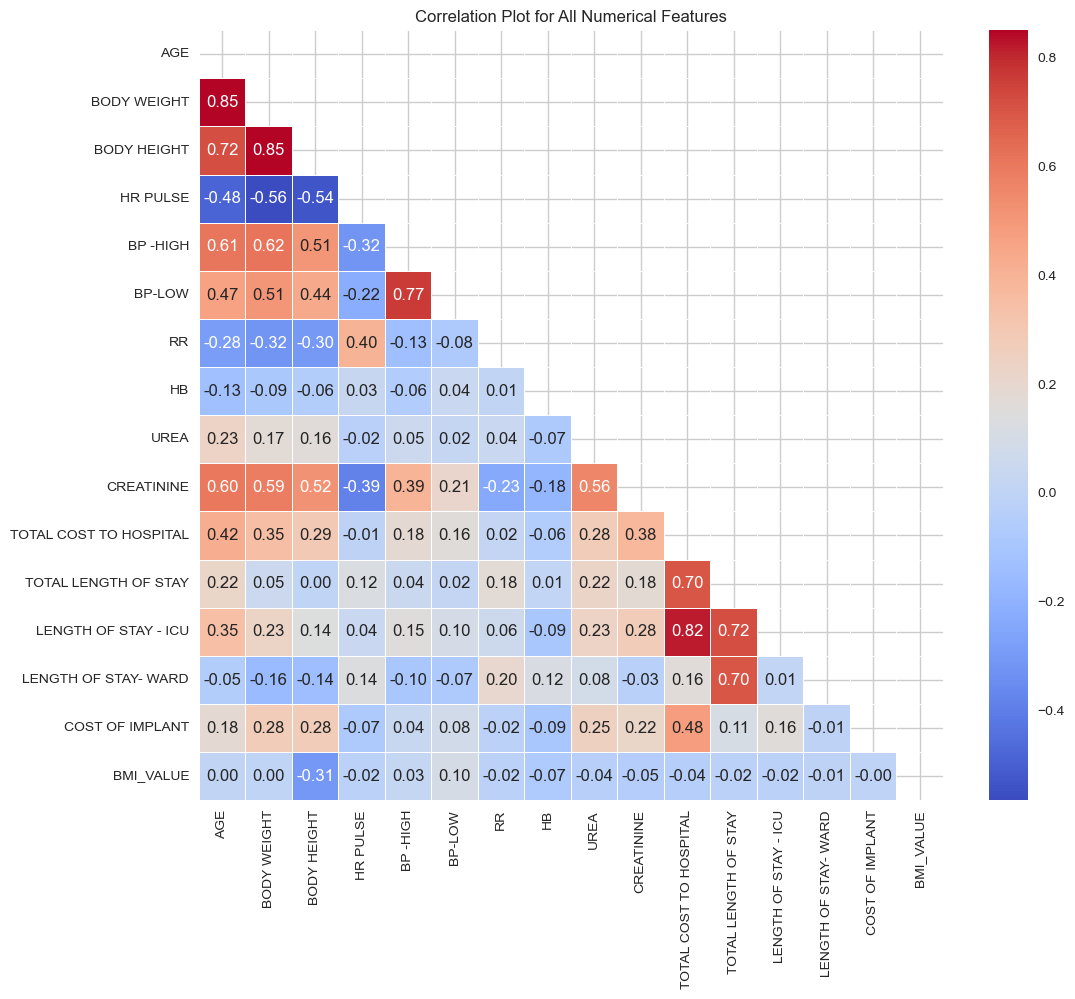

In [108]:
# Select only the numerical columns for the correlation matrix
numerical_df = data.select_dtypes(include=['float64', 'int64'])

# Drop the 'SL' column from the DataFrame
numerical_df = numerical_df.drop('SL.', axis=1)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
lower_triangle = np.tril(correlation_matrix)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, linewidths=.5)
plt.title('Correlation Plot for All Numerical Features')
plt.show()

#### 3.4.2 Total Cost To Hospital vs the rest of categorical features (ANOVA)

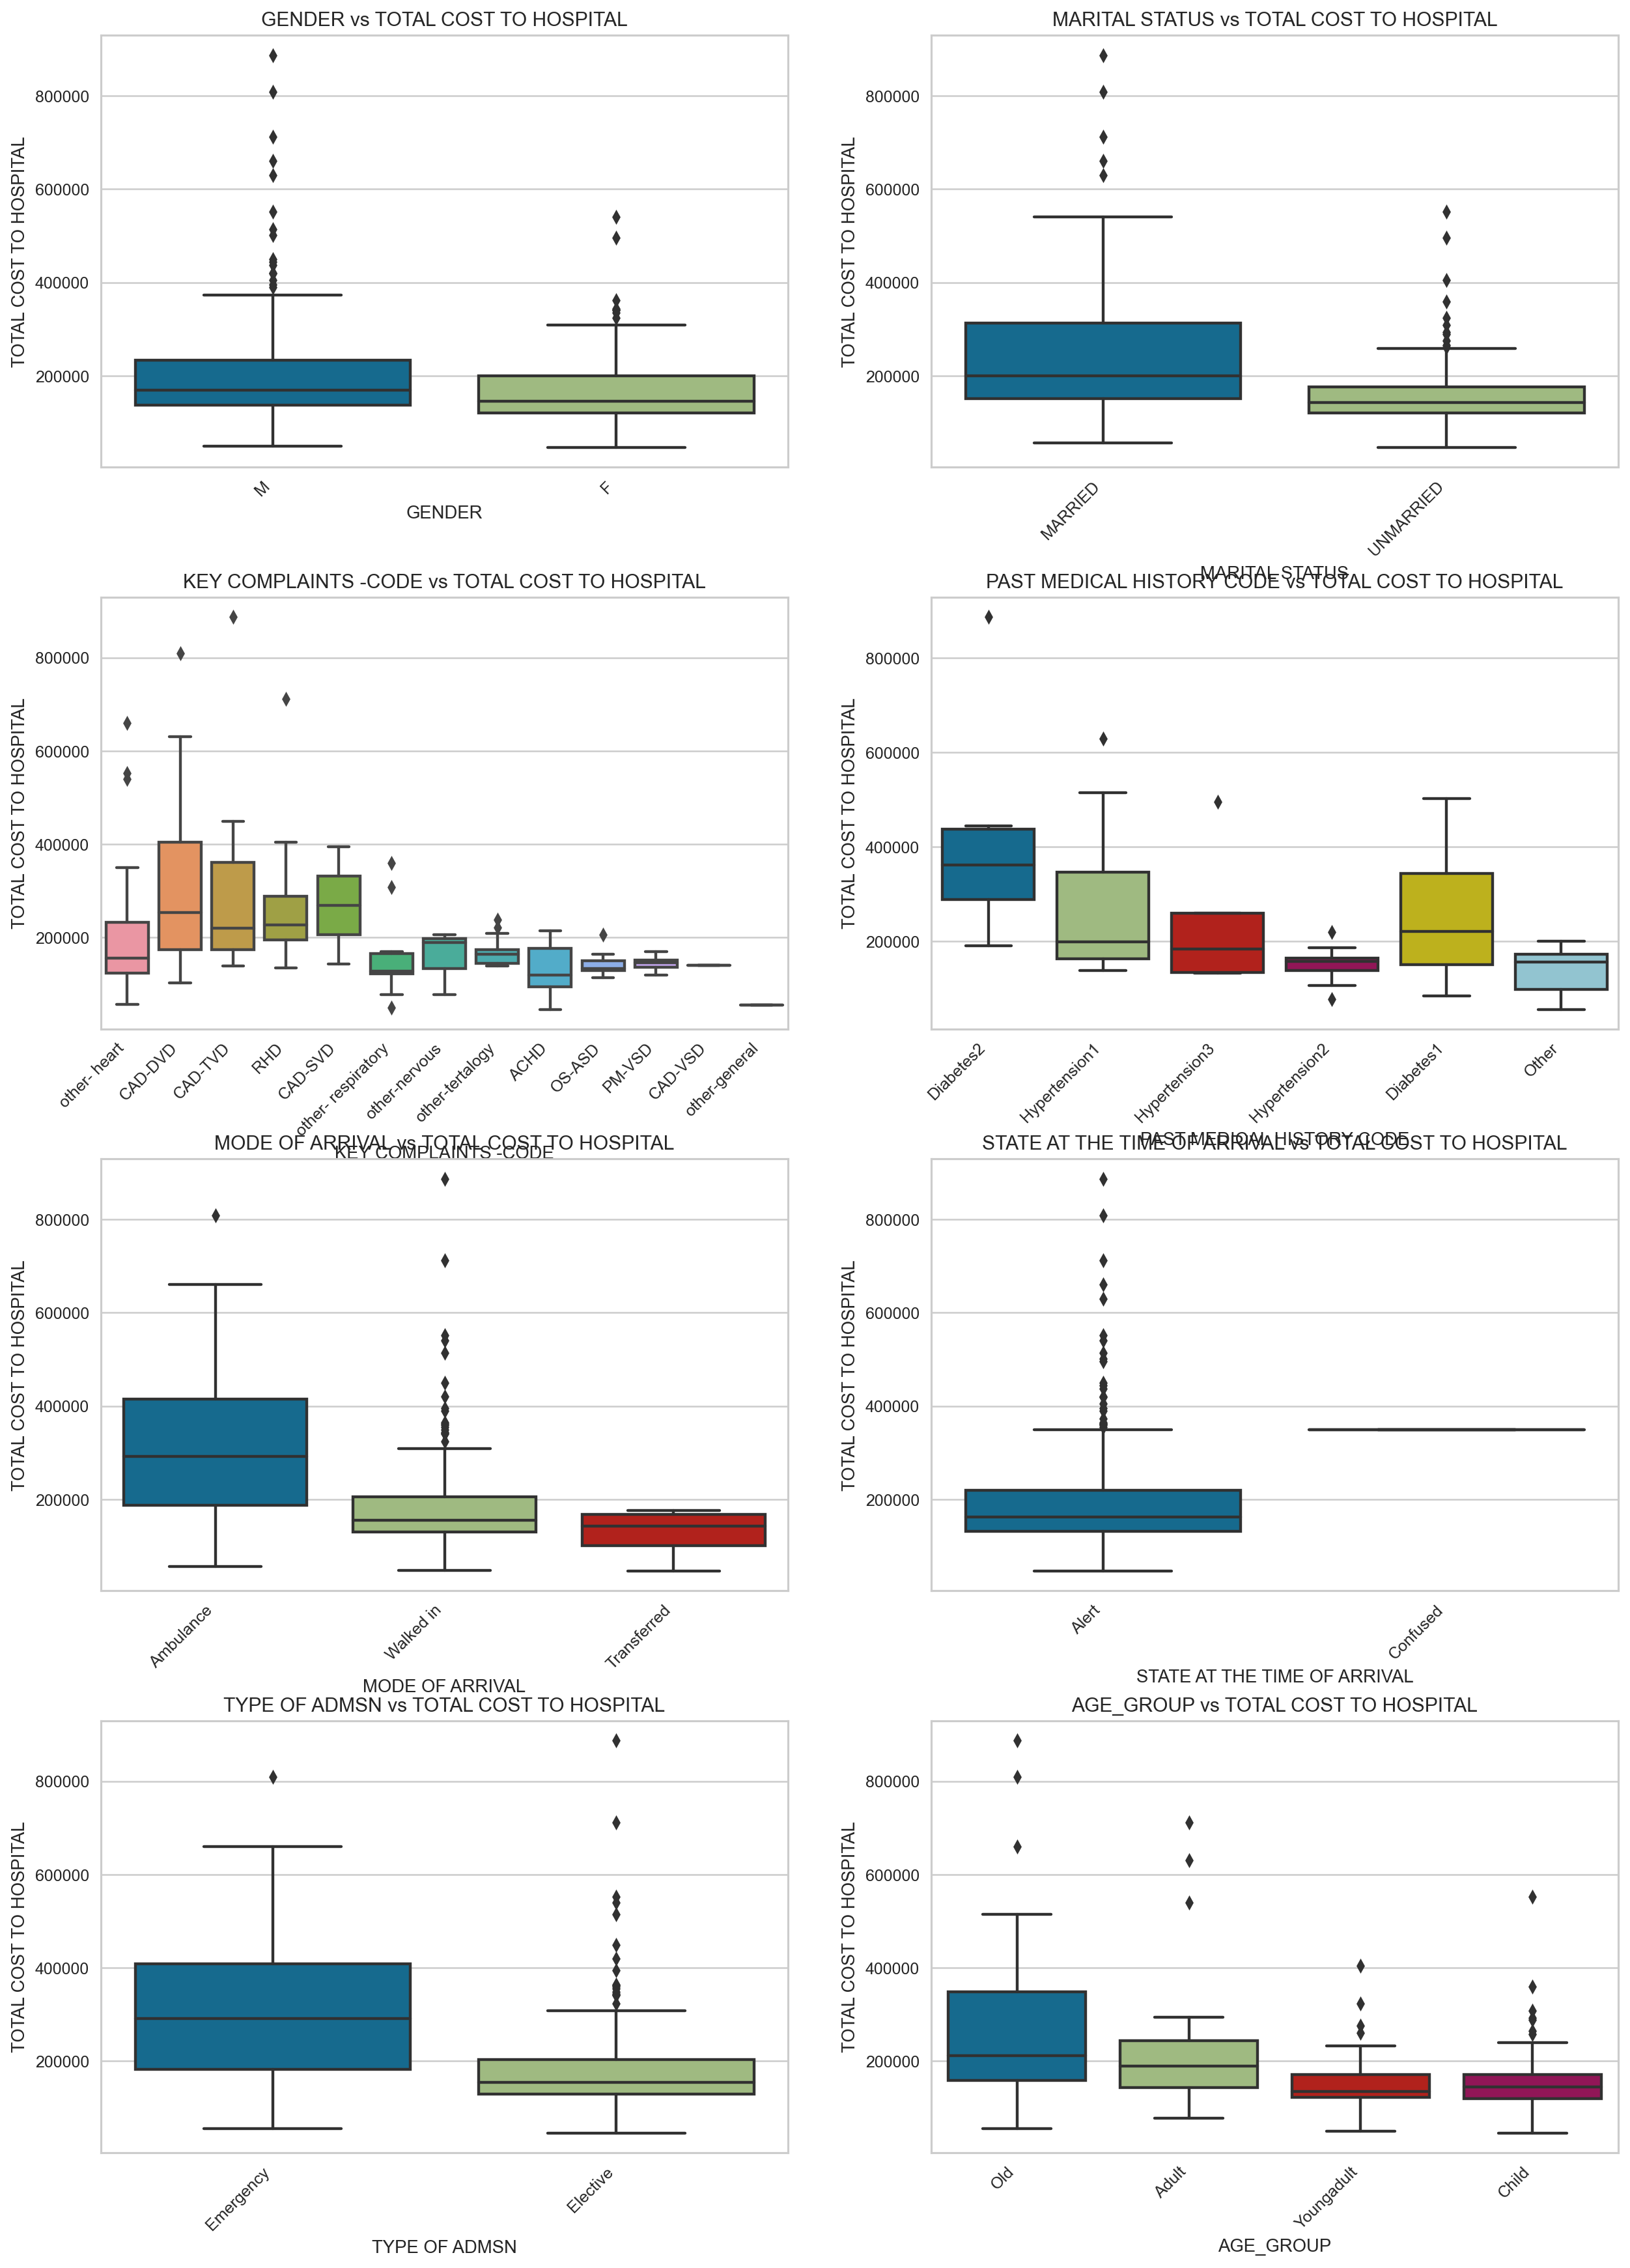

In [23]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['GENDER','MARITAL STATUS','KEY COMPLAINTS -CODE','PAST MEDICAL HISTORY CODE','MODE OF ARRIVAL','STATE AT THE TIME OF ARRIVAL','TYPE OF ADMSN','AGE_GROUP','UREA_LEVEL','BP_Cat','CREATININE_LEVEL','BMI','IMPLANT USED (Y/N)']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=data[cat_features[cat_ft_count]],y=data['TOTAL COST TO HOSPITAL'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs TOTAL COST TO HOSPITAL")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('TOTAL COST TO HOSPITAL')
            cat_ft_count += 1
    break

#### 3.4.2.1 Age vs the rest of categorical features

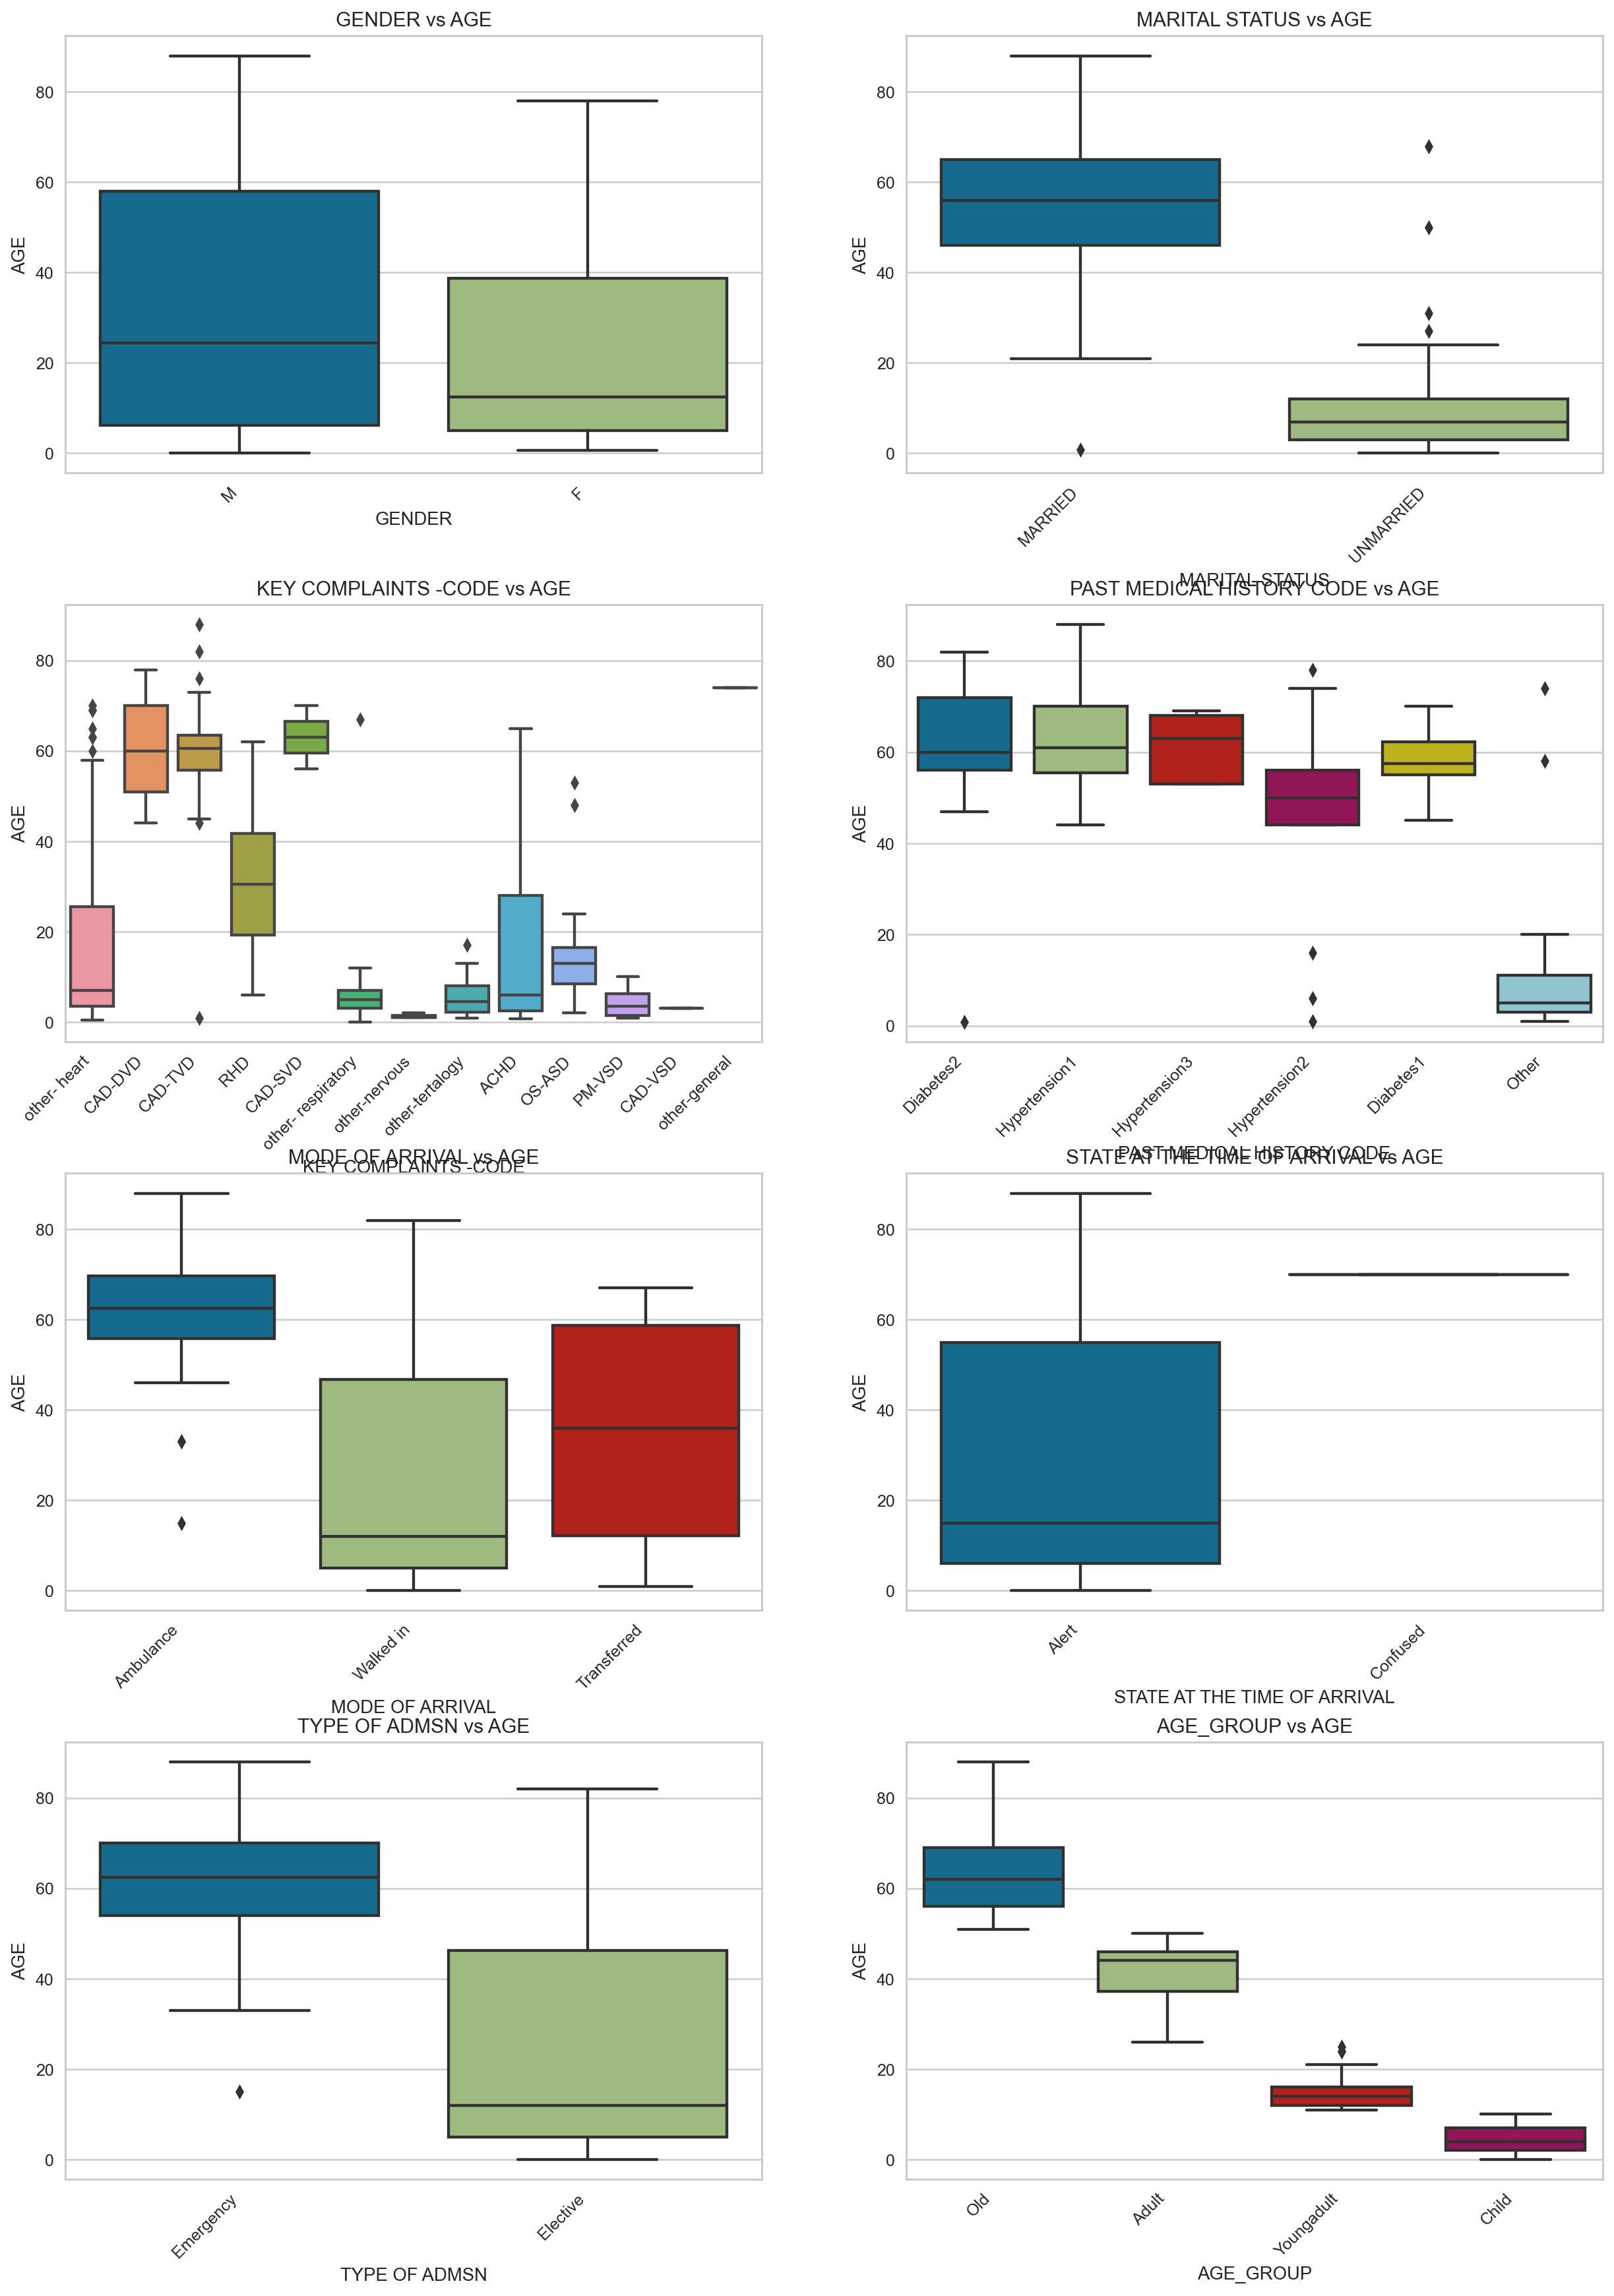

In [24]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['GENDER','MARITAL STATUS','KEY COMPLAINTS -CODE','PAST MEDICAL HISTORY CODE','MODE OF ARRIVAL','STATE AT THE TIME OF ARRIVAL','TYPE OF ADMSN','AGE_GROUP','UREA_LEVEL','BP_Cat','CREATININE_LEVEL','BMI','IMPLANT USED (Y/N)']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=data[cat_features[cat_ft_count]],y=data['AGE'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs AGE")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('AGE')
            cat_ft_count += 1
    break

#### 3.4.2.2 T-Tests

In [112]:
t_stat, p_val = stats.ttest_ind(data[data['GENDER'] == 'M']['TOTAL COST TO HOSPITAL'],
                                data[data['GENDER'] == 'F']['TOTAL COST TO HOSPITAL'])
print(f"T-Test: t_stat = {t_stat}, p_val = {p_val}")

T-Test: t_stat = 2.426358517880483, p_val = 0.015970815512801745


#### 3.4.2.3 ANOVA

In [113]:
f_stat, p_val = stats.f_oneway(data[data['AGE_GROUP'] == 'Child']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Youngadult']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Adult']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Old']['TOTAL COST TO HOSPITAL'])
print(f"ANOVA: f_stat = {f_stat}, p_val = {p_val}")

ANOVA: f_stat = 16.946836418025534, p_val = 4.959554830929893e-10


#### 3.4.2.4 Chi-Square Test

In [114]:
contingency_table = pd.crosstab(data['GENDER'], data['TYPE OF ADMSN'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square: chi2 = {chi2}, p_val = {p_val}")

Chi-Square: chi2 = 2.69952302434671, p_val = 0.1003782724854383


# 4. Prepare the data

## 4.2 Data Cleaning

### 4.2.1 Outliers handling

In [40]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['TOTAL LENGTH OF STAY', 'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'COST OF IMPLANT']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 4.2.2 Missing values imputer

In [41]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft = ['PAST MEDICAL HISTORY CODE', 'KEY COMPLAINTS -CODE'], median_imputed_ft = ['COST OF IMPLANT']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # drop missing values in the target feature
            df.dropna(inplace=True, axis=0, subset=['TOTAL COST TO HOSPITAL'])
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 4.3 Feature selection

### 4.3.1 Feature drop

In [42]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['AGE','SL.','HB','BMI','BP_Cat','CREATININE_LEVEL','RR','BODY WEIGHT','BODY HEIGHT','HR PULSE','BP -HIGH','BP-LOW','CREATININE','UREA','HB_LEVEL','UREA_LEVEL']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 4.4 Feature transformation

### 4.4.1 Min-Max scaling (with feature's names)

In [43]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['TOTAL LENGTH OF STAY','LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'BMI_VALUE', 'COST OF IMPLANT']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df): 
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 4.4.2 One hot encoding (with feature's name)

In [44]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=['AGE_GROUP', 'GENDER', 'MODE OF ARRIVAL', 'IMPLANT USED (Y/N)', 'MARITAL STATUS', 'KEY COMPLAINTS -CODE', 'PAST MEDICAL HISTORY CODE', 'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN']):
        self.one_hot_enc_ft = one_hot_enc_ft
        self.one_hot_enc = OneHotEncoder(handle_unknown='ignore')
    
    def fit(self, df, y=None):
        self.one_hot_enc.fit(df[self.one_hot_enc_ft])
        self.feat_names_one_hot_enc = self.one_hot_enc.get_feature_names_out(self.one_hot_enc_ft)
        return self
    
    def transform(self, df):
        if set(self.one_hot_enc_ft).issubset(df.columns):
            one_hot_enc_df = pd.DataFrame(self.one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(), columns=self.feat_names_one_hot_enc, index=df.index)
            rest_of_features = [ft for ft in df.columns if ft not in self.one_hot_enc_ft]
            df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]], axis=1)
            return df_concat
        else:
            print("One or more features are not in the dataframe")
            return df

### 4.4.3 Skewness Handler

In [45]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['TOTAL LENGTH OF STAY','BMI_VALUE','COST OF IMPLANT','LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found')
            return df

## 4.5 Data Preprocessing

In [46]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('missing value imputer', MissingValueImputer()),
        ('drop features', DropFeatures()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', MinMaxWithFeatNames()),
        ('one hot encoder', OneHotWithFeatNames())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [47]:
# Combine the datasets
combined_df = pd.concat([train_copy, test_copy], sort=False).reset_index(drop=True)

In [48]:
pd.options.mode.chained_assignment = None
full_data = full_pipeline(combined_df)

In [49]:
cost_amt_train_prep, cost_amt_test_prep = data_split(full_data, 0.2)

In [50]:
cost_amt_train_prep.shape

(155, 40)

In [51]:
cost_amt_test_prep.shape

(39, 40)

In [52]:
X_cost_amt_train_prep, y_cost_amt_train_prep = cost_amt_train_prep.loc[:, cost_amt_train_prep.columns != 'TOTAL COST TO HOSPITAL'], cost_amt_train_prep['TOTAL COST TO HOSPITAL']

In [53]:
pd.set_option('display.max_columns', None)
X_cost_amt_train_prep.head()

AGE_GROUP_Adult  AGE_GROUP_Child  AGE_GROUP_Old  AGE_GROUP_Youngadult  \
0              0.0              0.0            0.0                   1.0   
1              0.0              0.0            1.0                   0.0   
2              0.0              1.0            0.0                   0.0   
3              0.0              0.0            0.0                   1.0   
4              0.0              1.0            0.0                   0.0   

   GENDER_F  GENDER_M  MODE OF ARRIVAL_Ambulance  MODE OF ARRIVAL_Transferred  \
0       0.0       1.0                        0.0                          0.0   
1       0.0       1.0                        0.0                          0.0   
2       1.0       0.0                        0.0                          0.0   
3       0.0       1.0                        0.0                          1.0   
4       0.0       1.0                        0.0                          0.0   

   MODE OF ARRIVAL_Walked in  IMPLANT USED (Y/N)_N  MARITAL STATUS_Married  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     1.0   
2                        1.0                   1.0                     0.0   
3                        0.0                   1.0                     0.0   
4                        1.0                   1.0                     0.0   

   MARITAL STATUS_Unmarried  KEY COMPLAINTS -CODE_ACHD  \
0                       1.0                        0.0   
1                       0.0                        0.0   
2                       1.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        1.0   

   KEY COMPLAINTS -CODE_CAD-DVD  KEY COMPLAINTS -CODE_CAD-SVD  \
0                           0.0                           0.0   
1                           1.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   KEY COMPLAINTS -CODE_CAD-TVD  KEY COMPLAINTS -CODE_CAD-VSD  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   KEY COMPLAINTS -CODE_OS-ASD  KEY COMPLAINTS -CODE_PM-VSD  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   KEY COMPLAINTS -CODE_RHD  KEY COMPLAINTS -CODE_other- heart  \
0                       0.0                                1.0   
1                       0.0                                0.0   
2                       0.0                                0.0   
3                       0.0                                1.0   
4                       0.0                                0.0   

   KEY COMPLAINTS -CODE_other- respiratory  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   KEY COMPLAINTS -CODE_other-general  KEY COMPLAINTS -CODE_other-nervous  \
0                                 0.0                                 0.0   
1                                 0.0                                 0.0   
2                                 0.0                                 1.0   
3                                 0.0                                 0.0   
4                    

## 4.6 Multiple linear Regression

In [54]:
X_cost_amt_train = cost_amt_train_prep.loc[:, cost_amt_train_prep.columns != 'TOTAL COST TO HOSPITAL']
y_cost_amt_train = cost_amt_train_prep['TOTAL COST TO HOSPITAL']

In [55]:
X_sm = X_cost_amt_train = sm.add_constant(X_cost_amt_train)
model = sm.OLS(y_cost_amt_train, X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     TOTAL COST TO HOSPITAL   R-squared:                       0.825
Model:                                OLS   Adj. R-squared:                  0.785
Method:                     Least Squares   F-statistic:                     20.35
Date:                    Tue, 18 Jun 2024   Prob (F-statistic):           1.16e-34
Time:                            22:30:11   Log-Likelihood:                -1831.0
No. Observations:                     155   AIC:                             3722.
Df Residuals:                         125   BIC:                             3813.
Df Model:                              29                                         
Covariance Type:                nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
AGE_GROUP_Adult                         -1.721e+04   1.36e+04     -1.261      0.210   -4.42e+04    9791.427
AGE_GROUP_Child                          1.296e+04   1.33e+04      0.971      0.333   -1.34e+04    3.94e+04
AGE_GROUP_Old                           -6483.6427   1.35e+04     -0.480      0.632   -3.32e+04    2.03e+04
AGE_GROUP_Youngadult                     1.997e+04   1.34e+04      1.495      0.138   -6473.958    4.64e+04
GENDER_F                                 1787.4067   5355.873      0.334      0.739   -8812.531    1.24e+04
GENDER_M                                 7444.2702   5195.036      1.433      0.154   -2837.351    1.77e+04
MODE OF ARRIVAL_Ambulance                2.186e+04   2.05e+04      1.069      0.287   -1.86e+04    6.23e+04
MODE OF ARRIVAL_Transferred             -1.194e+04   2.01e+04     -0.594      0.554   -5.17e+04    2.79e+04
MODE OF ARRIVAL_Walked in                -686.9956   1.26e+04     -0.054      0.957   -2.57e+04    2.43e+04
IMPLANT USED (Y/N)_N                     9231.6769   7744.109      1.192      0.235   -6094.876    2.46e+04
MARITAL STATUS_Married                   2.183e+04   1.24e+04      1.760      0.081   -2712.925    4.64e+04
MARITAL STATUS_Unmarried                -1.259e+04   1.21e+04     -1.041      0.300   -3.65e+04    1.14e+04
KEY COMPLAINTS -CODE_ACHD                1.058e+04   1.19e+04      0.888      0.376    -1.3e+04    3.42e+04
KEY COMPLAINTS -CODE_CAD-DVD             2.947e+04   1.32e+04      2.228      0.028    3286.369    5.56e+04
KEY COMPLAINTS -CODE_CAD-SVD            -6.524e+04   3.62e+04     -1.800      0.074   -1.37e+05    6482.065
KEY COMPLAINTS -CODE_CAD-TVD               2.3e+04   1.33e+04      1.732      0.086   -3277.462    4.93e+04
KEY COMPLAINTS -CODE_CAD-VSD            -1046.5950   3.47e+04     -0.030      0.976   -6.97e+04    6.76e+04
KEY COMPLAINTS -CODE_OS-ASD              8710.1247   1.34e+04      0.649      0.517   -1.78e+04    3.53e+04
KEY COMPLAINTS -CODE_PM-VSD               2.38e+04   1.83e+04      1.303      0.195   -1.24e+04       6e+04
KEY COMPLAINTS -CODE_RHD                 1271.1302   3.55e+04      0.036      0.971    -6.9e+04    7.15e+04
KEY COMPLAINTS -CODE_other- heart        3853.8827   7897.264      0.488      0.626   -1.18e+04    1.95e+04
KEY COMPLAINTS -CODE_other- respiratory  1.994e+04   1.28e+04      1.562      0.121   -5325.513    4.52e+04
KEY COMPLAINTS -CODE_other-general      -4.684e+04   3.93e+04     -1.191      0.236   -1.25e+05     3.1e+04
KEY COMPLAINTS -CODE_other-nervous      -2.201e+04   2.13e+04     -1.032      0.304   -6.42e+04    2.02e+04
KEY COMPLAINTS -CODE_other-tertalogy     2.374e+04   1.15e+04      2.068      0.041    1019.886    4.65e+04
PAST MEDICAL HI

# 5. Short-list promising models

## 5.1 Model training

In [56]:
Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42),
    'Kernel Ridge Regression': KernelRidge(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
    'SVM Regression': SVR(),
    'Gaussian Process Regression': GaussianProcessRegressor(random_state=42),
    'Neural Network Regression': MLPRegressor(random_state=42)
}

In [57]:
def fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    rmse_scores_path = Path('saved_models/{0}/rmse_{0}'.format(model_name))
    try:
        #check if the file exists
        rmse_scores_path.resolve(strict=True)
    except FileNotFoundError:
        scores = cross_val_score(model, X_loan_amt_train_prep, y_loan_amt_train_prep, cv=3, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))
        joblib.dump(rmse_scores, 'saved_models/{0}/rmse_{0}'.format(model_name))
    else:
        rmse_scores = joblib.load('saved_models/{0}/rmse_{0}'.format(model_name))
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))

In [58]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}/'.format(model_name)):
        os.makedirs('saved_models/{}/'.format(model_name))

In [59]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    fit_score_model(model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep)





----------------------  Linear Regression  ----------------------


Score: [40017.8904451 50596.1848342 46531.8914539]
Mean score: 45715.32224440178
Standard deviation: 4356.999502795304




----------------------  Ridge Regression  ----------------------


Score: [39116.51398461 52520.22478694 39695.03269315]
Mean score: 43777.25715490063
Standard deviation: 6186.7214384365025




----------------------  Lasso Regression  ----------------------




C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+08, tolerance: 6.928e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+09, tolerance: 5.090e+07
  model = cd_fast.enet_coordinate_descent(


Score: [39791.64574314 50479.22339894 46497.12233078]
Mean score: 45589.33049095235
Standard deviation: 4410.150681896336




----------------------  Elastic Net Regression  ----------------------


Score: [58650.14031209 79799.09619709 58339.45944418]
Mean score: 65596.23198445317
Standard deviation: 10043.742480844505




----------------------  KNN Regression  ----------------------


Score: [49554.56406059 72827.20117532 51784.44468831]
Mean score: 58055.40330807373
Standard deviation: 10484.833525194997




----------------------  Decision Tree Regression  ----------------------


Score: [43506.13167259 58816.94051971 38714.2570188 ]
Mean score: 47012.44307036822
Standard deviation: 8573.219375787463




----------------------  Random Forest Regression  ----------------------


Score: [31458.14689254 44385.10274282 40861.51525912]
Mean score: 38901.58829816163
Standard deviation: 5456.343840460505




----------------------  Gradient Boosting Regression  ----------------------


S

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Score: [176248.65945475 197589.07280652 182111.06452582]
Mean score: 185316.26559569733
Standard deviation: 9002.15884958847


C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 5.2 Top 3 models

- Gradient Boosting Regression
- Extra Trees Regression
- Random Forest Regression

# 6. Fine tuning the model

In [60]:
def feat_importance(model_trn, model_name):
    # change xtick font size
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    # top 10 most predictive features
    top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
    # top 10 least predictive features
    bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
    #change the figure size
    plt.figure(figsize=(10, 4))
    #change x label font size
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    top_10_feat.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
    # show the plot
    top_10_feat.show()
    print('\n')
    plt.figure(figsize=(10, 4))
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    bottom_10_feat.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
    # show the plot
    bottom_10_feat.show()
    print('\n')

In [61]:
def shap_ft_importance(model_name, model,X_cost_amt_train_prep, y_cost_amt_train_prep):
    # get the model
    model = model
    # fit the model
    model.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
    # load JS visualization code to notebook
    shap.initjs()
    # get the shap values
    shap_values = shap.TreeExplainer(model).shap_values(X_cost_amt_train_prep)
    # get the feature importance
    shap_ft_importance = shap.summary_plot(shap_values,features=X_cost_amt_train_prep,feature_names=X_cost_amt_train_prep.columns, show=False)
    plt.savefig('saved_final_models/{0}/shap_ft_importance_{0}.png'.format(model_name))

In [62]:
def train_model(best_model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        #train the model with the best parameters
        best_model_trn = best_model.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [63]:
def fine_tune_model(model_name,model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
        rand_search.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    return best_model

In [64]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

## 6.1 Gradient Boosting Regression

In [65]:
parameters = [
    {
    'n_estimators':[100, 200, 300, 400],
    'max_depth':[3, 4, 5],
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
    'min_samples_split':[2,5,10],
    'subsample': [0.6, 0.8, 1.0],
    'max_features':['sqrt'],
    }
]

In [66]:
grad_boost_dict = {'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)}

In [67]:
model_name, model = list(grad_boost_dict.keys())[0], list(grad_boost_dict.values())[0]

In [68]:
best_model = fine_tune_model(model_name, model, parameters, X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
**************************************************
42497.97931580424 {'subsample': 0.6, 'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
42622.57942221519 {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.2}
37314.11068329078 {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
40902.249560199874 {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.2}
55564.58648040558 {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.01}
43739.10593196285 {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}
38126.263812918776 

In [69]:
best_grad_boost_trn = train_model(best_model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep)

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


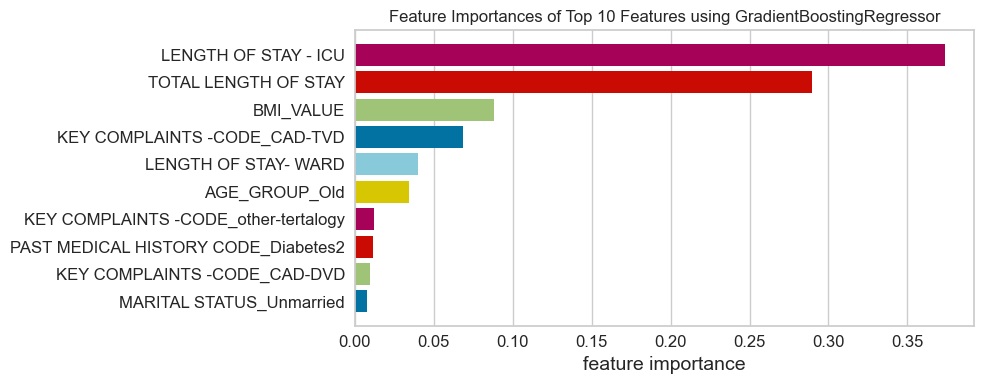

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


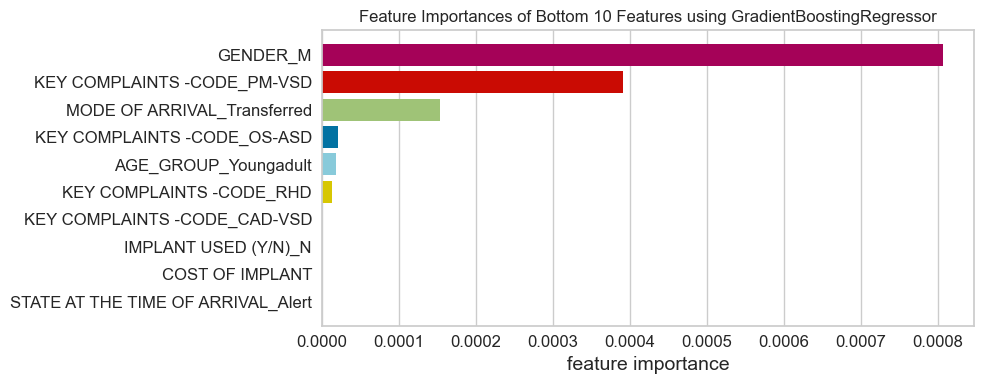

In [70]:
feat_importance(best_grad_boost_trn, model_name)

## 6.2 Extra Trees Regression

In [71]:
n_samples = X_cost_amt_train_prep.shape[0]
n_features = X_cost_amt_train_prep.shape[1]

parameters = [
    {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, n_samples//2, ],
    'min_samples_leaf': [1, 2, n_samples//2, ],
    'max_features': [None, 'sqrt', 'log2', 0.3, 0.5, n_features//2],
    'bootstrap':[True, False]
    }
]

In [72]:
extra_trees_dict = {'Extra Trees Regression': ExtraTreesRegressor(random_state=42)}

In [73]:
model_name, model = list(extra_trees_dict.keys())[0], list(extra_trees_dict.values())[0]

In [74]:
folder_check_model(model_name)

In [75]:
best_model = fine_tune_model(model_name, model, parameters, X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
**************************************************
78338.30653657204 {'n_estimators': 100, 'min_samples_split': 77, 'min_samples_leaf': 77, 'max_features': None, 'max_depth': 30, 'bootstrap': True}
78297.62398177912 {'n_estimators': 400, 'min_samples_split': 77, 'min_samples_leaf': 77, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
78338.30653657204 {'n_estimators': 100, 'min_samples_split': 77, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
44862.481158852475 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None, 'bootstrap': True}
53221.670151081904 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
78316.3883458785 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 77, 'max_features': 19, 'max_depth': 10, 'bootstrap': False}
78297

In [76]:
best_extra_tree_trn = train_model(best_model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep)

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


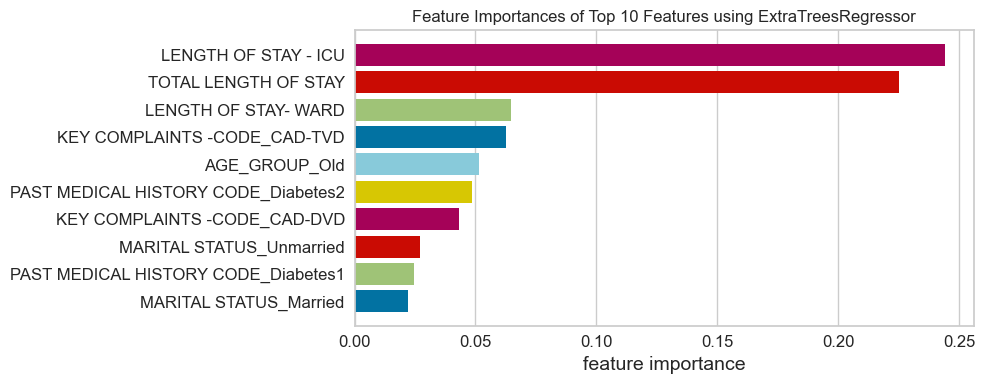

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


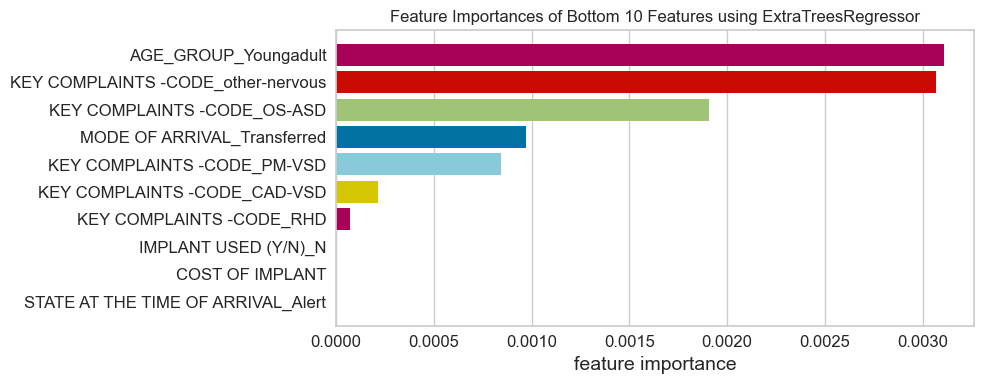

In [77]:
feat_importance(best_extra_tree_trn, model_name)

## 6.3 Random Forest Regression

In [78]:
parameters = [
    {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, None],
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 300]
    }
]

In [79]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [80]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [81]:
best_model = fine_tune_model(model_name, model, parameters, X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
**************************************************
44807.697354626514 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
42510.84276059753 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
47441.43534229594 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
46653.83198964999 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
48100.24525072965 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
50201.183231309486 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': Tr

In [68]:
best_rand_for_trn = train_model(best_model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep)

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


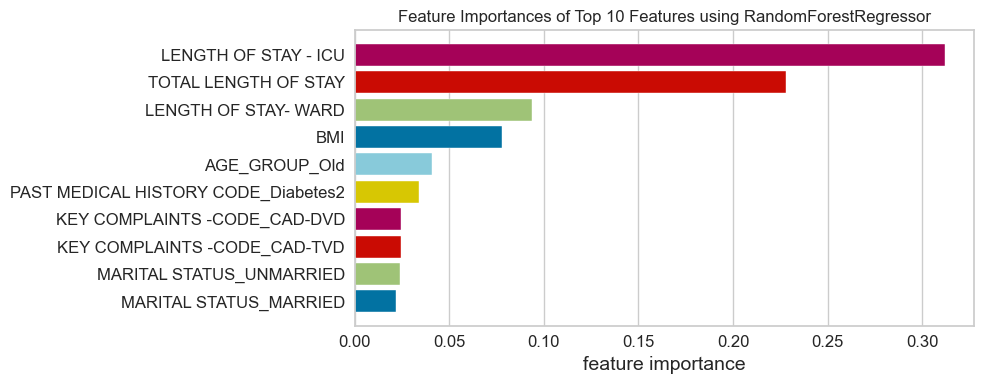

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


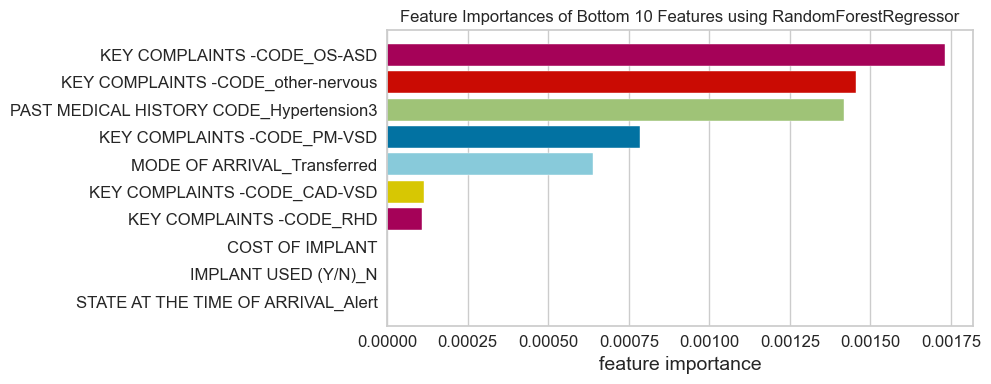

In [69]:
feat_importance(best_rand_for_trn, model_name)

## 6.4 Final model

In [82]:
best_grad_boost_trn

GradientBoostingRegressor(max_features='sqrt', min_samples_split=10,
                          random_state=42, subsample=0.8)

# 7. Test the final model on the test dataset

In [83]:
test_original.head()

SL.        AGE GENDER MARITAL STATUS KEY COMPLAINTS -CODE  BODY WEIGHT  \
0   34   7.000000      M      Unmarried   other- respiratory          7.0   
1    7  73.000000      M        Married              CAD-TVD         60.0   
2  183   0.416667      M      Unmarried         other- heart          4.7   
3   87   0.583333      F      Unmarried   other- respiratory          5.8   
4  157   4.000000      F      Unmarried               OS-ASD         13.4   

   BODY HEIGHT  HR PULSE  BP -HIGH  BP-LOW  RR PAST MEDICAL HISTORY CODE  \
0           68       155      91.0    45.0  30                       NaN   
1          170       108     160.0    90.0  24                 Diabetes2   
2           66       100       NaN     NaN  24                       NaN   
3           57       150       NaN     NaN  28                       NaN   
4           27       120     110.0    70.0  24                       NaN   

     HB  UREA  CREATININE MODE OF ARRIVAL STATE AT THE TIME OF ARRIVAL  \
0  13.0  16.0         NaN       Walked in                        Alert   
1  14.5  31.0         1.6       Walked in                        Alert   
2  20.4   NaN         NaN       Walked in                        Alert   
3  11.3  38.0         0.5       Walked in                        Alert   
4  10.4  18.0         0.3       Walked in                        Alert   

  TYPE OF ADMSN  TOTAL COST TO HOSPITAL  TOTAL LENGTH OF STAY  \
0      Elective                359280.0                    22   
1      Elective                887350.0                    15   
2      Elective                233376.0                    17   
3      Elective                308817.0                    27   
4      Elective                132226.0                    10   

   LENGTH OF STAY - ICU  LENGTH OF STAY- WARD IMPLANT USED (Y/N)  \
0                    12                    10                  N   
1                    15                     0                  N   
2                     3                    14                  Y   
3                    12                    15                  N   
4                     2                     8                  N   

   COST OF IMPLANT AGE_GROUP HB_LEVEL UREA_LEVEL   BMI_VALUE          BMI  \
0                0     Child   Normal     Normal   15.138408  Underweight   
1                0       Old   Normal   Abnormal   20.761246       Normal   
2            26000     Child   Normal   Abnormal   10.789715  Underweight   
3                0     Child   Normal   Abnormal   17.851647  Underweight   
4                0     Child      Low     Normal  183.813443        Obese   

                 BP_Cat CREATININE_LEVEL  
0                Normal         Abnormal  
1  Hypertension Stage 2         Abnormal  
2   Hypertensive Crisis         Abnormal  
3   Hypertensive Crisis           Normal  
4                Normal         Abnormal

## 7.1 Data preprocessing for the test set

In [84]:
pd.set_option('display.max_columns', None)
cost_amt_test_prep.head()

AGE_GROUP_Adult  AGE_GROUP_Child  AGE_GROUP_Old  AGE_GROUP_Youngadult  \
0              0.0              1.0            0.0                   0.0   
1              0.0              1.0            0.0                   0.0   
2              0.0              1.0            0.0                   0.0   
3              0.0              0.0            0.0                   1.0   
4              0.0              1.0            0.0                   0.0   

   GENDER_F  GENDER_M  MODE OF ARRIVAL_Ambulance  MODE OF ARRIVAL_Transferred  \
0       0.0       1.0                        0.0                          0.0   
1       0.0       1.0                        0.0                          0.0   
2       0.0       1.0                        0.0                          0.0   
3       0.0       1.0                        0.0                          0.0   
4       0.0       1.0                        0.0                          0.0   

   MODE OF ARRIVAL_Walked in  IMPLANT USED (Y/N)_N  MARITAL STATUS_Married  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     0.0   
2                        1.0                   1.0                     0.0   
3                        1.0                   1.0                     0.0   
4                        1.0                   1.0                     0.0   

   MARITAL STATUS_Unmarried  KEY COMPLAINTS -CODE_ACHD  \
0                       1.0                        0.0   
1                       1.0                        0.0   
2                       1.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   KEY COMPLAINTS -CODE_CAD-DVD  KEY COMPLAINTS -CODE_CAD-SVD  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   KEY COMPLAINTS -CODE_CAD-TVD  KEY COMPLAINTS -CODE_CAD-VSD  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   KEY COMPLAINTS -CODE_OS-ASD  KEY COMPLAINTS -CODE_PM-VSD  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          1.0                          0.0   
4                          0.0                          0.0   

   KEY COMPLAINTS -CODE_RHD  KEY COMPLAINTS -CODE_other- heart  \
0                       0.0                                0.0   
1                       0.0                                0.0   
2                       0.0                                0.0   
3                       0.0                                0.0   
4                       0.0                                1.0   

   KEY COMPLAINTS -CODE_other- respiratory  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      0.0   
4                                      0.0   

   KEY COMPLAINTS -CODE_other-general  KEY COMPLAINTS -CODE_other-nervous  \
0                                 0.0                                 0.0   
1                                 0.0                                 0.0   
2                                 0.0                                 0.0   
3                                 0.0                                 0.0   
4                    

In [85]:
X_cost_amt_test, y_cost_amt_test = cost_amt_test_prep.loc[:, cost_amt_test_prep.columns != 'TOTAL COST TO HOSPITAL'], cost_amt_test_prep['TOTAL COST TO HOSPITAL']

## 7.2 R-squared on the Test Set

In [86]:
final_predictions = best_grad_boost_trn.predict(X_cost_amt_test)

In [87]:
final_mse = mean_squared_error(y_cost_amt_test, final_predictions)

In [88]:
final_rmse = np.sqrt(final_mse)

In [89]:
final_rmse

27518.771950134123

## 7.3 Confidence Intervals

In [90]:
confidence = 0.95

In [91]:
squared_errors = (final_predictions - y_cost_amt_test) ** 2

In [92]:
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

In [93]:
print('The confidence interval at 95% is between {0:.2f} and {1:.2f}'.format(ci[0], ci[1]))

The confidence interval at 95% is between 20016.53 and 33375.20
